# Purpose:
- Develop and run neural stretching
    - First replicate previous results from the test sessions.
    - Then run all training sessions.
    - Per volume
- Touch responses
    - All touches
    - Before and after decision.
- Population responses
    - Before sampling, during sampling, during decision, after pole down
- Distance between angles
- Distance within an angle
    - Correct, wrong, miss
- Selecting subset of neurons
    - Touch neurons, whisking neurons, reward neurons, etc.
        - Use the coding score.
            - Both absolute score (from all neurons) and relative score (from fit neurons, VE >= 0.05)


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
import utils.matched_roi as mr
from importlib import reload

# base_dir = Path(r'E:\TPM\JK\h5')
base_dir = Path(r'C:\JK')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]

In [6]:
mouse = 25
volume = 1
top_plane = 1 if volume == 1 else 5
sessions = use_mice_df.query('mouse == @mouse and plane == @top_plane').session.unique().astype(int)
print(sessions)

[ 1  2  3  4  5  6 13 15 17 19]


In [7]:
session = 19
planes = range(top_plane, top_plane + 4)


In [80]:
# get touch response from one plane
plane = planes[0]
plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

# remove trials with errors
refined_ophys_frametime = ophys_frametime.query('remove_trial==False').reset_index(drop=True)
assert refined_ophys_frametime.remove_frame.values.sum() == 0

# merge refined_ophys_frametime and behavior_frametime
reduced_behavior_columns = np.setdiff1d(behavior_frametime.columns,np.setdiff1d(refined_ophys_frametime.columns, ['trialNum', 'frame_index']))
reduced_behavior_df = behavior_frametime[reduced_behavior_columns]
merged_df = pd.merge(refined_ophys_frametime, reduced_behavior_df, on=['trialNum', 'frame_index'], how='inner')

# Assigne pole_moving_up and pole_moving_down to the frames
# First check if all trials have correct pole up pole moving frames
# Sometimes there is no pole_moving_frame
# Just use -1 of the first pole up and +1 of pole up frame as pole_in_frame and pole_out_frame
assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame']==1)[0])==0).any()
merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==True)[0][0]-1]).reset_index(drop=True).values
merged_df['pole_out_frame'] = merged_df.groupby('trialNum').apply(lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==True)[0][-1]+1]).reset_index(drop=True).values



In [81]:
# touch response per trial
spks = np.load(roi_dir / 'spks_reduced.npy')
iscell = np.load(roi_dir / 'iscell.npy')
cell_inds = np.where(iscell[:,0]==1)[0]
spks = spks[cell_inds,:]
assert spks.shape[1] == len(merged_df)
norm_spks = spks / spks.max(axis=1)[:,np.newaxis]
merged_df['spks_frame_ind'] = np.arange(spks.shape[1])

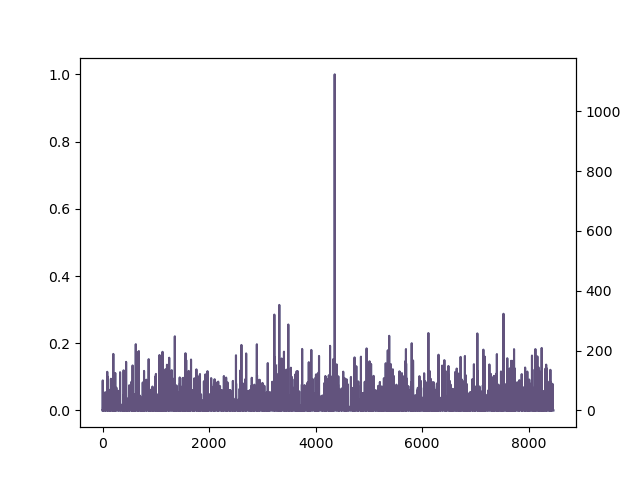

In [82]:
ci = 10
fig, ax = plt.subplots()
ax.plot(norm_spks[ci,:])
axx = ax.twinx()
axx.plot(spks[ci,:], color='r', alpha=0.3)

In [83]:
merged_df.touch_count.unique()

array([nan,  2.,  1.,  3.,  4.])

In [84]:
# touch response frames = touch frames + 0,1,2 frames
# per trial, to prevent touch rollover when pole was up till the end of the trial
def _get_touch_response_frames(x, post_touch_frames=2):
    touch_frame_inds = np.where(x['touch_count']>0)[0]    
    touch_response_frame_inds = np.unique((touch_frame_inds[:,None] + np.arange(post_touch_frames+1)).flatten())
    touch_response_frames = x['frame_index'].values[touch_response_frame_inds]
    return touch_response_frames
touch_response_frames = merged_df.groupby('trialNum').apply(_get_touch_response_frames)
touch_response_frames = np.concatenate(touch_response_frames.values)
merged_df['touch_response'] = merged_df['frame_index'].isin(touch_response_frames)

In [87]:
# QC touch_response frame (True False)
trialNums = merged_df.trialNum.unique()
merged_df[merged_df.trialNum==trialNums[30]][['frame_index', 'touch_count', 'touch_response']]

frame_index  touch_count  touch_response
1153        1214          NaN           False
1154        1215          NaN           False
1155        1216          NaN           False
1156        1217          NaN           False
1157        1218          NaN           False
1158        1219          NaN           False
1159        1220          NaN           False
1160        1221          NaN           False
1161        1222          1.0            True
1162        1223          4.0            True
1163        1224          NaN            True
1164        1225          NaN            True
1165        1226          NaN           False
1166        1227          3.0            True
1167        1228          1.0            True
1168        1229          1.0            True
1169        1230          1.0            True
1170        1231          3.0            True
1171        1232          3.0            True
1172        1233          1.0            True
1173        1234          2.0            True
1174        1235          2.0            True
1175        1236          1.0            True
1176        1237          2.0            True
1177        1238          NaN            True
1178        1239          NaN            True
1179        1240          NaN           False
1180        1241          NaN           False
1181        1242          NaN           False

In [88]:
# Get touch response of spks per trial
touch_trial_nums = merged_df[merged_df.touch_response].trialNum.unique()

per_touch_responses = []
for tn in touch_trial_nums:
    trial_df = merged_df[merged_df.trialNum==tn]
    touch_response_frame_inds = trial_df[trial_df.touch_response].spks_frame_ind
    touch_response_spks = np.sum(norm_spks[:,touch_response_frame_inds], axis=1)
    # assert len(touch_response_spks) == norm_spks.shape[0]
    num_touch = np.nansum(trial_df.touch_count.values)
    per_touch_responses.append(touch_response_spks / num_touch)

per_touch_response_df = pd.DataFrame({'trialNum': touch_trial_nums, 'per_touch_response': per_touch_responses})
len(per_touch_response_df)

200

In [89]:
per_touch_response_df = pd.merge(per_touch_response_df, merged_df[['trialNum', 'pole_angle', 'correct', 'wrong', 'miss']].drop_duplicates(), on='trialNum', how='inner')
len(per_touch_response_df)

200

(200, 97)
(20, 97)
(28, 97)
(19, 97)
(57, 97)
(21, 97)
(23, 97)
(32, 97)


Text(0.5, 0, 'PC3')

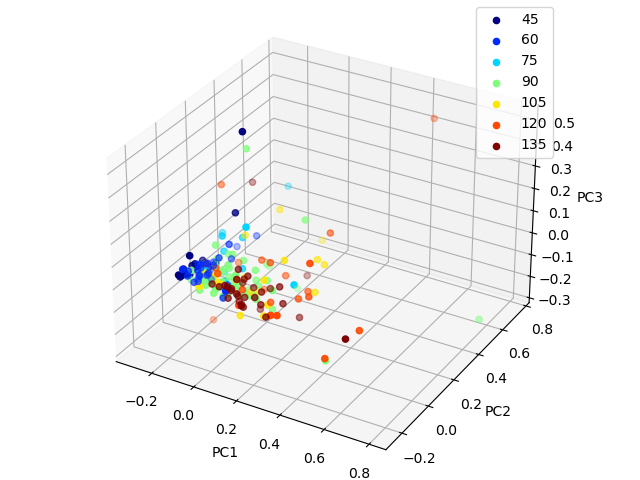

In [90]:
# run PCA on responses

responses_all = per_touch_response_df.per_touch_response.values
responses_all = np.stack(responses_all)
print(responses_all.shape)
pca = PCA(n_components=3)
pca.fit(responses_all)
# plot the 3d results
%matplotlib widget
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

angles = np.unique(per_touch_response_df.pole_angle)
colors = plt.cm.jet(np.linspace(0,1,len(angles)))
for ai, angle in enumerate(angles):
    responses_angle = per_touch_response_df[per_touch_response_df.pole_angle==angle].per_touch_response.values
    responses_angle = np.stack(responses_angle)
    print(responses_angle.shape)
    pc = pca.transform(responses_angle)
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], color=colors[ai], label=angle)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


In [7]:
# look at the volume data
def get_merged_df(ophys_frametime, behavior_frametime):
    # remove trials with errors
    refined_ophys_frametime = ophys_frametime.query('remove_trial==False')
    assert refined_ophys_frametime.remove_frame.values.sum() == 0

    # merge refined_ophys_frametime and behavior_frametime
    reduced_behavior_columns = np.setdiff1d(behavior_frametime.columns,
                                            np.setdiff1d(refined_ophys_frametime.columns,
                                                         ['trialNum', 'frame_index']))
    reduced_behavior_df = behavior_frametime[reduced_behavior_columns]
    merged_df = pd.merge(refined_ophys_frametime, reduced_behavior_df,
                         on=['trialNum', 'frame_index'], how='inner')
    return merged_df


def assign_pole_moving_frames(merged_df):
    # Assigne pole_moving_up and pole_moving_down to the frames
    # First check if all trials have correct pole up pole moving frames
    # Sometimes there is no pole_moving_frame
    # Just use -1 of the first pole up and +1 of pole up frame as pole_in_frame and pole_out_frame
    
    merged_df = merged_df.query('trial_type != "oo"').reset_index(drop=True)
    assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame'] == 1)[0]) == 0).any()
    values_to_assign = merged_df.groupby('trialNum').apply(
        lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame'] == 1)[0][0] - 1]).reset_index(
        drop=True).values
    assert len(values_to_assign) == len(merged_df)
    merged_df['pole_in_frame'] = values_to_assign
    values_to_assign = merged_df.groupby('trialNum').apply(apply_pole_out).reset_index(
            drop=True).values
    assert len(values_to_assign) == len(merged_df)
    merged_df['pole_out_frame'] = values_to_assign

    return merged_df


def apply_pole_out(x):
     '''Apply pole_out_frame to the merged_df
     It is the last frame of pole_up_frame.
     It should be when pole out sound cue is on.
     If it stayed up till the end, then it is ambiguous, so don't apply it.
     '''
     if np.where(x['pole_up_frame']==True)[0][-1] < len(x)-1:
          return (x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==1)[0][-1]]).reset_index(drop=True)
     else:
          return pd.Series([False]*len(x))


def assign_touch_response_frames(merged_df, post_touch_frames=1):
    # get touch response frames
    # add before_answer_touch_frame and after_answer_touch_frame
    touch_response_frames = merged_df.groupby('trialNum').apply(lambda x: _get_touch_response_frames(x,post_touch_frames=post_touch_frames))
    touch_response_frames = np.concatenate(touch_response_frames.values)
    values_to_assign = merged_df['frame_index'].isin(touch_response_frames).values
    assert len(values_to_assign) == len(merged_df)
    merged_df['touch_response_frame'] = values_to_assign
    merged_df['before_answer_touch_frame'] = False
    merged_df['before_answer_touch_count'] = np.nan
    merged_df = merged_df.groupby('trialNum').apply(_get_before_answer_touch_frames)    
    merged_df['after_answer_touch_frame'] = False
    merged_df['after_answer_touch_count'] = np.nan
    merged_df = merged_df.groupby('trialNum').apply(_get_after_answer_touch_frames)
    return merged_df


def _get_touch_response_frames(x, post_touch_frames=1):
    # touch response frames = touch frames + 0,1,2 frames
    # per trial, to prevent touch rollover when pole was up till the end of the trial
    touch_frame_inds = np.where(x['touch_count']>0)[0]    
    touch_response_frame_inds = np.unique((touch_frame_inds[:,None] + np.arange(post_touch_frames+1)).flatten())
    touch_response_frame_inds = touch_response_frame_inds[touch_response_frame_inds < len(x)]
    touch_response_frames = x['frame_index'].values[touch_response_frame_inds]
    return touch_response_frames


def _get_before_answer_touch_frames(x):    
    if np.where(x['answer_lick_frame'])[0].size == 0:
        return x
    else:
        answer_lick_frame_ind = np.where(x['answer_lick_frame'])[0][0]
        x.iloc[:answer_lick_frame_ind]['before_answer_touch_frame'] = x.iloc[:answer_lick_frame_ind]['touch_response_frame']
        x.iloc[:answer_lick_frame_ind]['before_answer_touch_count'] = x.iloc[:answer_lick_frame_ind]['touch_count']
    return x


def _get_after_answer_touch_frames(x):
    if np.where(x['answer_lick_frame'])[0].size == 0:
        return x
    else:
        answer_lick_frame_ind = np.where(x['answer_lick_frame'])[0][0]        
        x.iloc[answer_lick_frame_ind+1:]['after_answer_touch_frame'] = x.iloc[answer_lick_frame_ind+1:]['touch_response_frame']
        x.iloc[answer_lick_frame_ind+1:]['after_answer_touch_count'] = x.iloc[answer_lick_frame_ind+1:]['touch_count']
    return x


def get_touch_response(mouse, session, plane, touch_window='before_answer',
                       spk_norm='std', post_touch_frames=1):
    assert touch_window in ['before_answer', 'after_answer', 'all'],\
                'touch_window should be either "before_answer", "after_answer", or "all"'
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
    roi_dir = plane_dir / f'{session:03}/plane0/roi'
    ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

    # get merged df
    merged_df = get_merged_df(ophys_frametime, behavior_frametime)
    # assign pole_moving_up and pole_moving_down to the frames
    merged_df = assign_pole_moving_frames(merged_df)

    # get spks
    norm_spks = get_normalized_spikes(roi_dir, ophys_frametime, merged_df, spk_norm=spk_norm)
    
    merged_df['spks_frame_ind'] = np.arange(norm_spks.shape[1])

    # get touch response frames
    merged_df = assign_touch_response_frames(merged_df, post_touch_frames=post_touch_frames)

    # Get touch response of spks per trial
    if touch_window == 'before_answer':
        touch_trial_nums = merged_df[merged_df.before_answer_touch_frame].trialNum.unique()
    elif touch_window == 'after_answer':
        touch_trial_nums = merged_df[merged_df.after_answer_touch_frame].trialNum.unique()
    else:
        touch_trial_nums = merged_df[merged_df.touch_response_frame].trialNum.unique()
    merged_df = merged_df[merged_df.trialNum.isin(touch_trial_nums)]
    merged_df['num_touch'] = np.nan

    per_touch_responses = []
    for tn in touch_trial_nums:
        trial_df = merged_df[merged_df.trialNum==tn]
        
        if touch_window == 'before_answer':
            touch_response_frame_inds = trial_df[trial_df.before_answer_touch_frame].spks_frame_ind
            num_touch = np.nansum(trial_df.before_answer_touch_count.values)
        elif touch_window == 'after_answer':
            touch_response_frame_inds = trial_df[trial_df.after_answer_touch_frame].spks_frame_ind
            num_touch = np.nansum(trial_df.after_answer_touch_count.values)
        else:
            touch_response_frame_inds = trial_df[trial_df.touch_response_frame].spks_frame_ind
            num_touch = np.nansum(trial_df.touch_count.values)
        merged_df.loc[merged_df.trialNum==tn,'num_touch'] = num_touch
        touch_response_spks = np.sum(norm_spks[:,touch_response_frame_inds], axis=1)
        per_touch_responses.append(touch_response_spks / num_touch)
    cell_ids = [f'p{plane}c{ci:04}' for ci in norm_spks.cell_index.values]
    per_touch_response_xr = xr.DataArray(per_touch_responses,
                                         dims=['trialNum', 'cell_id'],
                                         coords={'trialNum': touch_trial_nums, 'cell_id': cell_ids})
    per_touch_response_df = merged_df[['trialNum', 'pole_angle', 'correct', 'wrong', 'miss', 'num_touch']].drop_duplicates()
    return per_touch_response_xr, per_touch_response_df


def get_normalized_spikes(roi_dir, ophys_frametime, merged_df, spk_norm='std'):
    spks = np.load(roi_dir / 'spks_reduced.npy')
    iscell = np.load(roi_dir / 'iscell.npy')
    cell_inds = np.where(iscell[:,0]==1)[0]
    spks = spks[cell_inds,:]
    assert spks.shape[1] == len(ophys_frametime)
    # deal with mismatched length
    if len(ophys_frametime) != len(merged_df):    
        removed_inds = np.where(ophys_frametime.frame_index.isin(merged_df.frame_index) == False)[0]
        # removed_tns = ophys_frametime.iloc[removed_inds].trialNum.unique()
        # print(f'JK{mouse:03} S{session:02} plane {plane} ophys_frametime and merged_df length mismatch:')
        # print(f'{len(removed_inds)} frames, {len(removed_tns)} trials')    
        spks = np.delete(spks, removed_inds, axis=1)
    assert spks.shape[1] == len(merged_df)

    # normalize spikes
    if spk_norm == 'std':
        norm_spks = (spks - spks.mean(axis=1)[:,np.newaxis]) / spks.std(axis=1)[:,np.newaxis]
    elif spk_norm == 'max':
        norm_spks = spks / spks.max(axis=1)[:,np.newaxis]
    elif spk_norm == 'none':
        norm_spks = spks
    else:
        raise ValueError('spk_norm should be either "std", "max", or "none"')
    norm_spks = xr.DataArray(norm_spks,
                             dims=('cell_index', 'frame_index'),
                             coords={'cell_index': cell_inds, 'frame_index': merged_df.frame_index.values},
                             attrs={'event_normalization': spk_norm})
    return norm_spks

In [61]:
mouse = 25
session = 19
planes = range(1, 5)
for pi, plane in enumerate(planes):
    per_touch_response_xr_plane, per_touch_response_df_plane = \
        get_touch_response(mouse, session, plane, touch_window='all')
    if pi == 0:
        per_touch_response_xr = per_touch_response_xr_plane.copy()
        per_touch_response_df = per_touch_response_df_plane.copy()
    else:
        assert per_touch_response_df.equals(per_touch_response_df_plane)
        assert per_touch_response_xr.shape[0] == per_touch_response_xr_plane.shape[0]
        assert per_touch_response_xr.trialNum.equals(per_touch_response_xr_plane.trialNum)
        per_touch_response_xr = xr.concat([per_touch_response_xr, per_touch_response_xr_plane], dim='cell_id')


Text(0, 0.5, 'PC2')

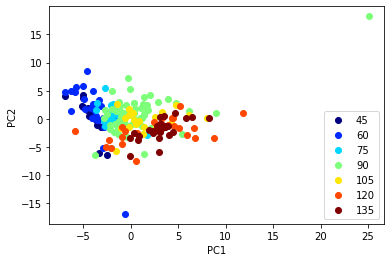

In [62]:
# Run PCA on the volume data
responses_all = per_touch_response_xr.values
pca = PCA()
pca.fit(responses_all)
%matplotlib inline
fig, ax = plt.subplots()

angles = np.unique(per_touch_response_df.pole_angle)
colors = plt.cm.jet(np.linspace(0,1,len(angles)))
for ai, angle in enumerate(angles):
    angle_tns = per_touch_response_df[per_touch_response_df.pole_angle==angle].trialNum.values
    responses_angle = per_touch_response_xr.sel(trialNum=angle_tns).values    
    pc = pca.transform(responses_angle)
    ax.scatter(pc[:,0], pc[:,1], color=colors[ai], label=angle)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')


In [8]:
def get_touch_response_volume_xr(mouse, top_plane, session, touch_window='before_answer',
                                 spk_norm='std', post_touch_frames=1):
    assert touch_window in ['before_answer', 'after_answer', 'all'],\
                'touch_window should be either "before_answer", "after_answer", or "all"'
    planes = range(top_plane, top_plane + 4)
    for pi, plane in enumerate(planes):
        per_touch_response_xr_plane, per_touch_response_df_plane = \
            get_touch_response(mouse, session, plane, touch_window=touch_window,
                               spk_norm=spk_norm, post_touch_frames=post_touch_frames)
        if pi == 0:
            per_touch_response_xr = per_touch_response_xr_plane.copy()
            per_touch_response_df = per_touch_response_df_plane.copy()
            touch_trial_nums = per_touch_response_xr_plane.trialNum.values
        else:
            # assert per_touch_response_df.equals(per_touch_response_df_plane)
            # assert per_touch_response_xr.shape[0] == per_touch_response_xr_plane.shape[0]
            # assert per_touch_response_xr.trialNum.equals(per_touch_response_xr_plane.trialNum)
            touch_trial_nums = np.intersect1d(touch_trial_nums, per_touch_response_xr_plane.trialNum.values)            
            per_touch_response_xr = xr.concat([per_touch_response_xr.sel(trialNum=touch_trial_nums),
                                               per_touch_response_xr_plane.sel(trialNum=touch_trial_nums)],
                                               dim='cell_id')
        per_touch_response_df = per_touch_response_df[per_touch_response_df.trialNum.isin(touch_trial_nums)]
        assert np.equal(per_touch_response_xr.trialNum.values, per_touch_response_df.trialNum.values).all()

    return per_touch_response_xr, per_touch_response_df


def draw_pca_touch_response(mouse, top_plane, session, ax, touch_window='before_answer',
                            spk_norm='std', post_touch_frames=1, pcs=[0,1]):
    assert touch_window in ['before_answer', 'after_answer', 'all'],\
                'touch_window should be either "before_answer", "after_answer", or "all"'

    per_touch_response_xr, per_touch_response_df = \
        get_touch_response_volume_xr(mouse, top_plane, session, touch_window=touch_window,
                                     spk_norm=spk_norm, post_touch_frames=post_touch_frames)
    responses_all = per_touch_response_xr.values
    pca = PCA()
    pca.fit(responses_all)
    angles = np.unique(per_touch_response_df.pole_angle)
    colors = plt.cm.jet(np.linspace(0,1,len(angles)))
    for ai, angle in enumerate(angles):
        angle_tns = per_touch_response_df[per_touch_response_df.pole_angle==angle].trialNum.values
        responses_angle = per_touch_response_xr.sel(trialNum=angle_tns).values    
        pc = pca.transform(responses_angle)
        ax.scatter(pc[:,pcs[0]], pc[:,pcs[1]], color=colors[ai], label=angle)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_title(f'JK{mouse:03} Volume {volume} Session {session:02}')
    ax.set_xlabel(f'PC{pcs[0]+1}')
    ax.set_ylabel(f'PC{pcs[1]+1}')
    return ax

        

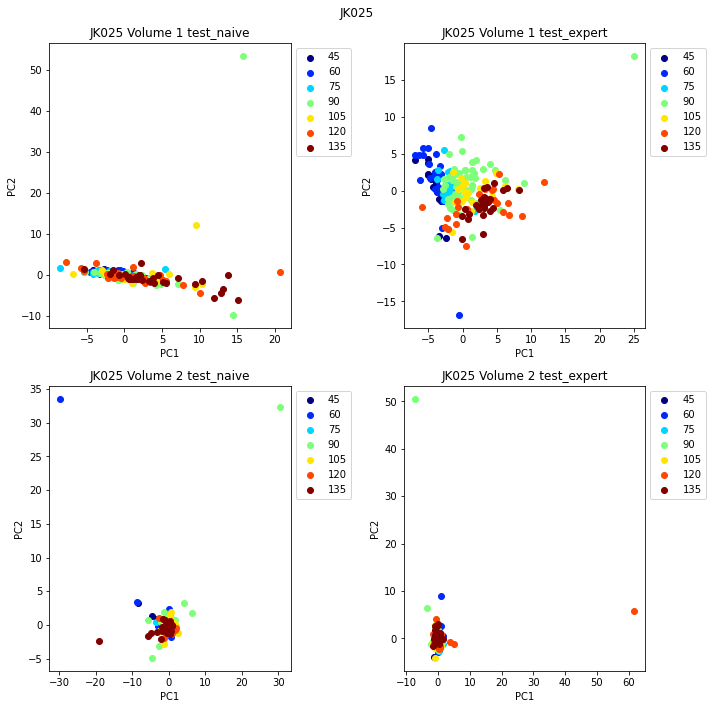

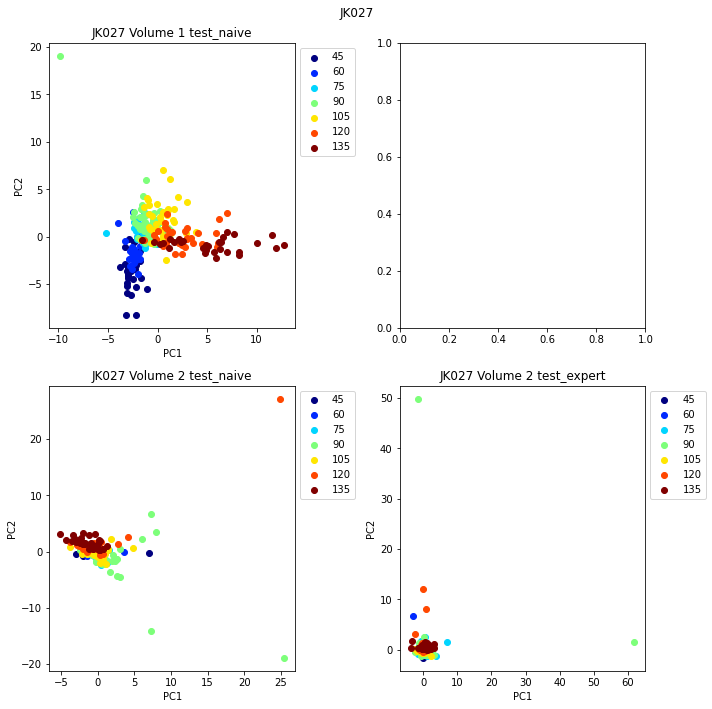

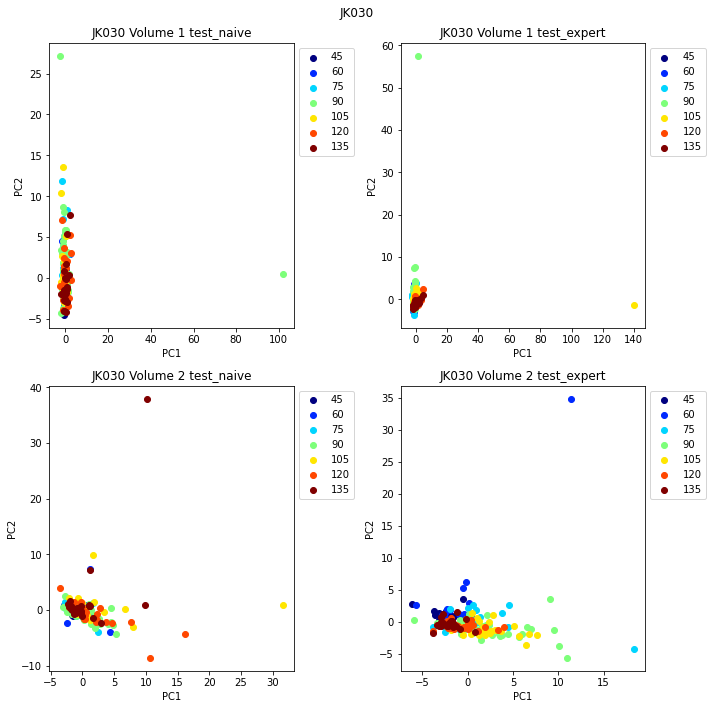

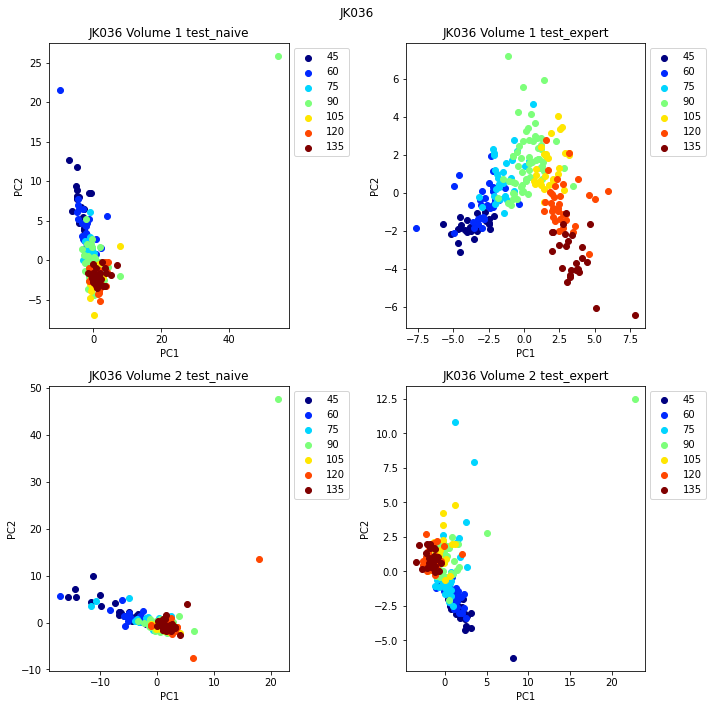

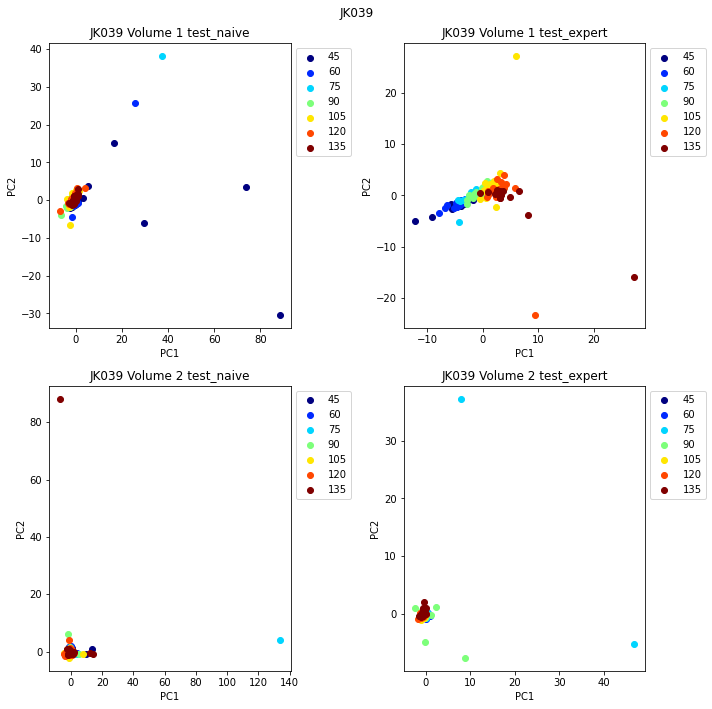

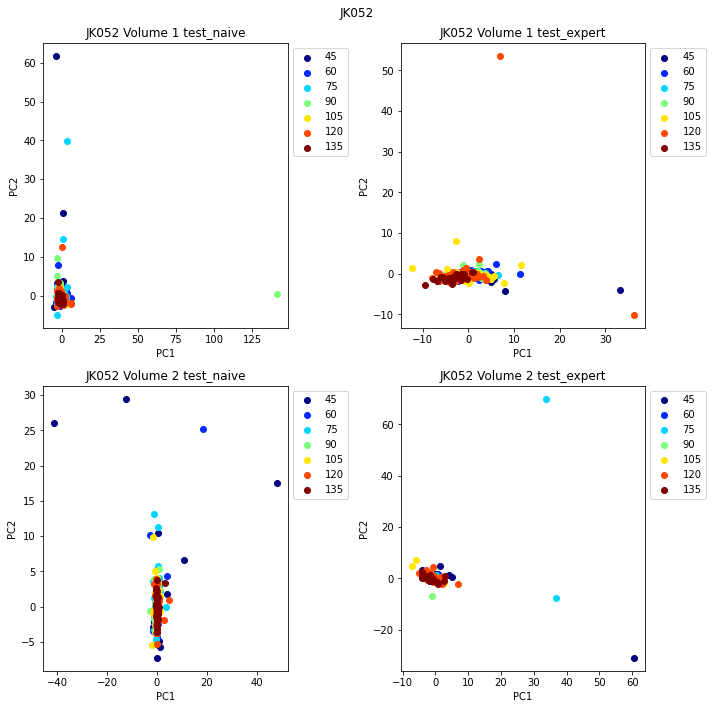

In [15]:
for mi in range(len(mice)):
    mouse = mice[mi]
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    for vi in range(2):
        if vi == 0:
            volume = 1
            top_plane = 1
        else:
            volume = 2
            top_plane = 5
        draw_pca_touch_response(use_mice_df, mouse, top_plane, test_sessions[mi][0], ax[vi,0])
        draw_pca_touch_response(use_mice_df, mouse, top_plane, test_sessions[mi][1], ax[vi,1])
    fig.suptitle(f'JK{mouse:03}')
    fig.tight_layout()

# PCA conditions
- spike normalization
- touch response normalization
- activity or touch responsivity
- filter miss trials

### Try with a single example
- expert session of JK025 lower volume

In [9]:
mi = 0
mouse = mice[mi]
session = test_sessions[mi][1]
top_plane = 5
spk_norm = 'std'
per_touch_response_xr, per_touch_response_df = \
    get_touch_response_volume_xr(mouse, top_plane, session, touch_window='all',
                                spk_norm=spk_norm)


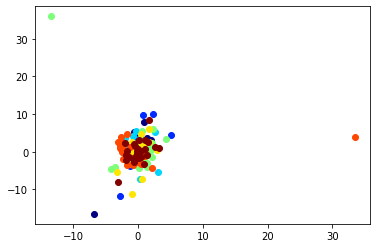

In [10]:
fig, ax = plt.subplots()
responses_all = per_touch_response_xr.values
responses_all = (responses_all - responses_all.mean(axis=0)) / responses_all.std(axis=0)
pcs = [0,1]
pca = PCA()
pca.fit(responses_all)
angles = np.unique(per_touch_response_df.pole_angle)
colors = plt.cm.jet(np.linspace(0,1,len(angles)))
for ai, angle in enumerate(angles):
    angle_tns = per_touch_response_df[per_touch_response_df.pole_angle==angle].trialNum.values
    responses_angle = per_touch_response_xr.sel(trialNum=angle_tns).values
    responses_angle = (responses_angle - responses_angle.mean(axis=0)) / responses_angle.std(axis=0)
    pc = pca.transform(responses_angle)
    ax.scatter(pc[:,pcs[0]], pc[:,pcs[1]], color=colors[ai], label=angle)

### spk normalization or response standardization did not help
- try filtering based on fit

In [328]:
per_touch_response_xr

<xarray.DataArray (trialNum: 202, cell_id: 505)>
array([[0.04141761, 0.        , 0.00727311, ..., 0.        , 0.0105234 ,
        0.02473129],
       [0.00446365, 0.14457586, 0.03723075, ..., 0.        , 0.        ,
        0.        ],
       [0.03077099, 0.        , 0.00905973, ..., 0.00410701, 0.00049171,
        0.00421588],
       ...,
       [0.04346347, 0.        , 0.00625913, ..., 0.00964641, 0.00240867,
        0.02265437],
       [0.19960973, 0.042966  , 0.00267532, ..., 0.01404023, 0.00572118,
        0.00389929],
       [0.01455027, 0.        , 0.00480643, ..., 0.00103102, 0.        ,
        0.00503732]], dtype=float32)
Coordinates:
  * trialNum  (trialNum) object 15 19 20 21 32 33 34 ... 434 435 437 438 439 440
  * cell_id   (cell_id) <U7 'p5c0000' 'p5c0001' ... 'p8c0133' 'p8c0134'

In [4]:
def get_glm_results(base_dir, mouse, plane, session):
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    roi_dir = plane_dir / f'{session:03}/plane0/roi'
    glm_dir = roi_dir / 'glm/touch_combined'
    glm_result = xr.open_dataset(glm_dir / 'glm_result.nc')
    return glm_result


def get_cell_inds_varexp_threshold(per_touch_response_xr, glm_result, plane, varexp_threshold=0.05):
    # get cell ids with varexp_model_final > varexp_threshold
    cell_ids = glm_result.cell_id.values
    varexp_model_final = glm_result.varexp_model_final.values
    cell_ids = cell_ids[varexp_model_final > varexp_threshold]
    return np.where([cid in [f'p{plane}c{ci:04}' for ci in cell_ids] for cid in per_touch_response_xr.cell_id.values])[0]


def get_touch_response_xr_varexp_threshold(mouse, top_plane, session, touch_window='before_answer',
                                           spk_norm='std', varexp_threshold=0.05,
                                           post_touch_frames=2):
    assert touch_window in ['before_answer', 'after_answer', 'all'],\
                'touch_window should be either "before_answer", "after_answer", or "all"'
    per_touch_response_xr, per_touch_response_df = \
        get_touch_response_volume_xr(mouse, top_plane, session, touch_window=touch_window,
                                    spk_norm=spk_norm, post_touch_frames=post_touch_frames)
    fit_cell_inds = []
    for plane in range(top_plane, top_plane+4):
        glm_result = get_glm_results(base_dir, mouse, plane, session)
        cell_inds = get_cell_inds_varexp_threshold(per_touch_response_xr, glm_result, plane, varexp_threshold=varexp_threshold)
        fit_cell_inds.extend(cell_inds)
    per_touch_response_xr_fit = per_touch_response_xr.isel(cell_id=fit_cell_inds)
    assert len(fit_cell_inds) == per_touch_response_xr_fit.shape[1]
    return per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr

In [12]:
per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    get_touch_response_xr_varexp_threshold(mouse, top_plane, session, spk_norm=spk_norm, varexp_threshold=0.05)

In [369]:
responses_all = per_touch_response_xr.values
responses_all.mean(axis=1).shape

(202,)

In [368]:
per_touch_response_xr.dims

('trialNum', 'cell_id')

In [367]:
responses_all.shape

(202, 505)

In [30]:
def _draw_pca(response_xr, response_df, ax, standardization=True, pcs=[0,1]):
    responses_all = response_xr.copy()
    if standardization:
        responses_all = (responses_all - responses_all.mean(axis=0)) / responses_all.std(axis=0)
    pca = PCA()
    pca.fit(responses_all)
    angles = np.unique(response_df.pole_angle)
    colors = plt.cm.jet(np.linspace(0,1,len(angles)))
    for ai, angle in enumerate(angles):
        angle_tns = response_df[response_df.pole_angle==angle].trialNum.values
        responses_angle = responses_all.sel(trialNum=angle_tns).values        
        pc = pca.transform(responses_angle)
        ax.scatter(pc[:,pcs[0]], pc[:,pcs[1]], color=colors[ai], label=angle)
    return ax



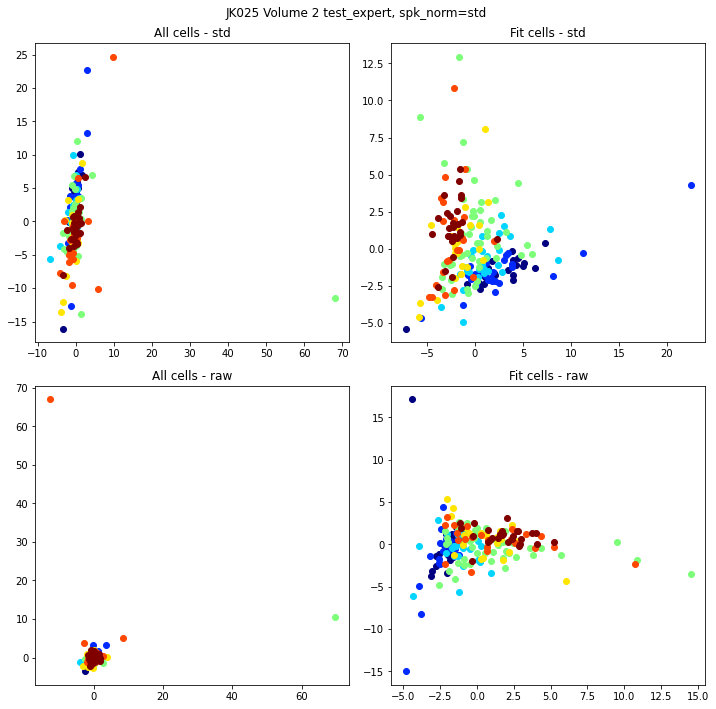

In [18]:
volume = 2
top_plane = 1 if volume ==1 else 5
spk_norm = 'std'
per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    get_touch_response_xr_varexp_threshold(mouse, top_plane, session, spk_norm=spk_norm, varexp_threshold=0.05)
fig, ax = plt.subplots(2,2, figsize=(10,10))
pcs=[0,1]
_draw_pca(per_touch_response_xr, per_touch_response_df, ax[0,0], standardization=True, pcs=pcs)
ax[0,0].set_title('All cells - std')
_draw_pca(per_touch_response_xr_fit, per_touch_response_df, ax[0,1], standardization=True, pcs=pcs)
ax[0,1].set_title('Fit cells - std')
_draw_pca(per_touch_response_xr, per_touch_response_df, ax[1,0], standardization=False, pcs=pcs)
ax[1,0].set_title('All cells - raw')
_draw_pca(per_touch_response_xr_fit, per_touch_response_df, ax[1,1], standardization=False, pcs=pcs)
ax[1,1].set_title('Fit cells - raw')
fig.suptitle(f'JK{mouse:03} Volume {volume} Session {session:02}, spk_norm={spk_norm}')
fig.tight_layout()

### neural stretching observed when using raw touch response from fit cells, regardless of spike normalization methods. 
- But it's gone when standardizing touch responses again. 
- Why?
- First, check this across volumes

In [15]:
use_mice_df.query('mouse == @mouse and plane == @top_plane and session_type == @session_type')

Unnamed: 0.1  mouse  plane session session_type  depth_matched  \
1358          1358     52      5      21  test_expert           True   

      processing_error remove_frame_ind  
1358             False                0

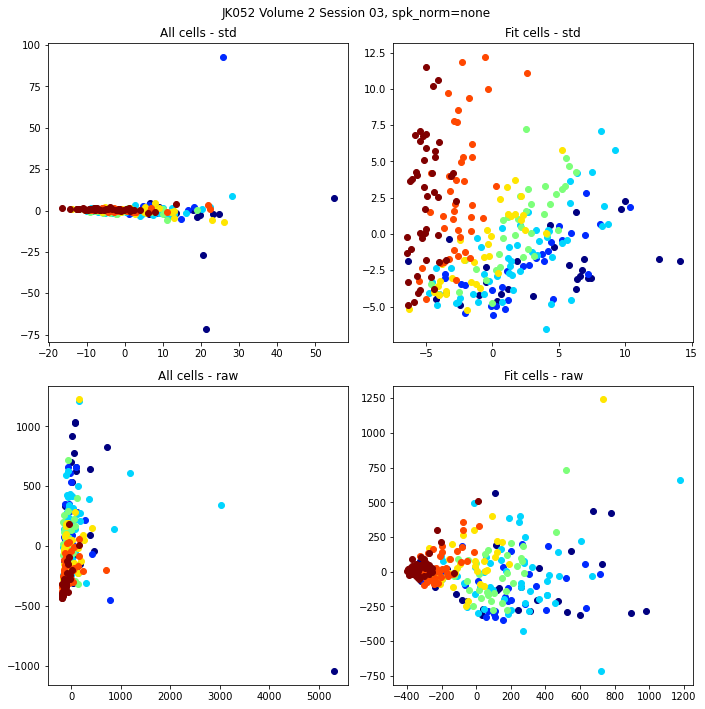

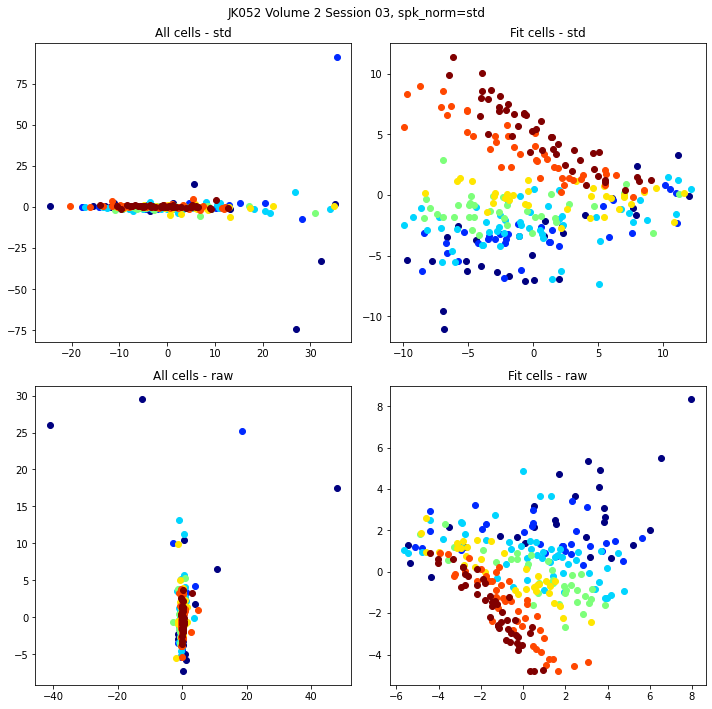

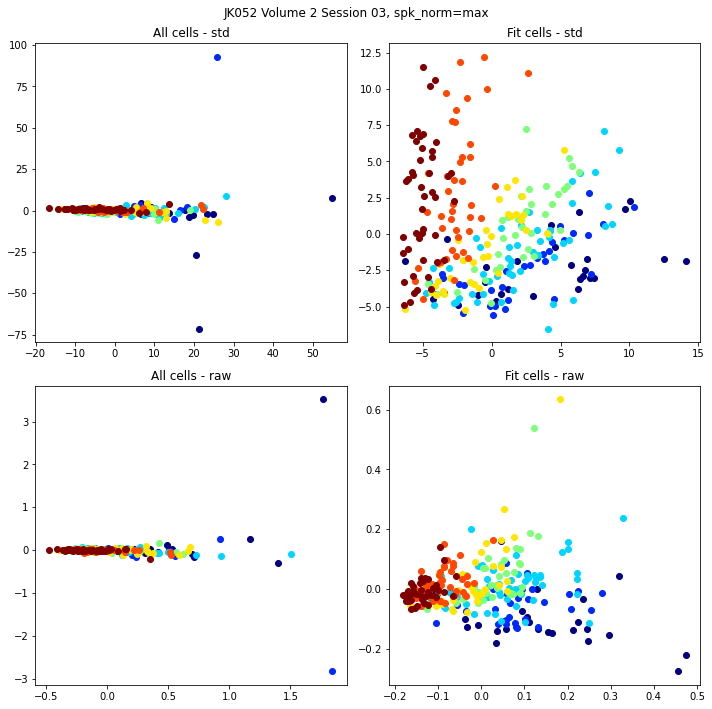

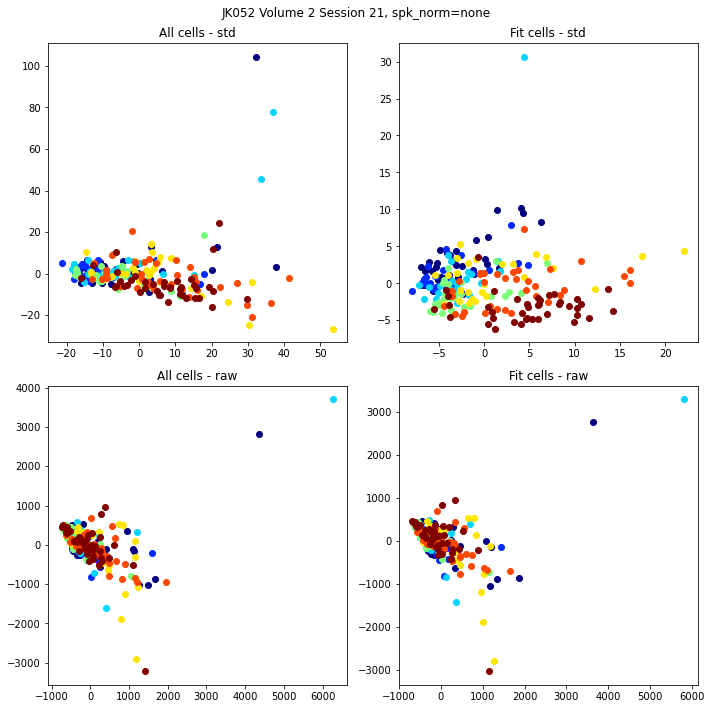

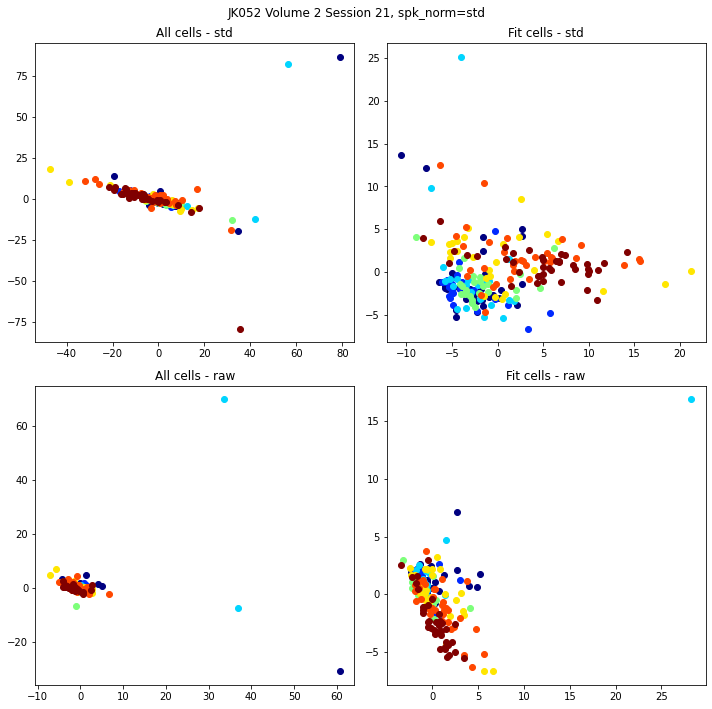

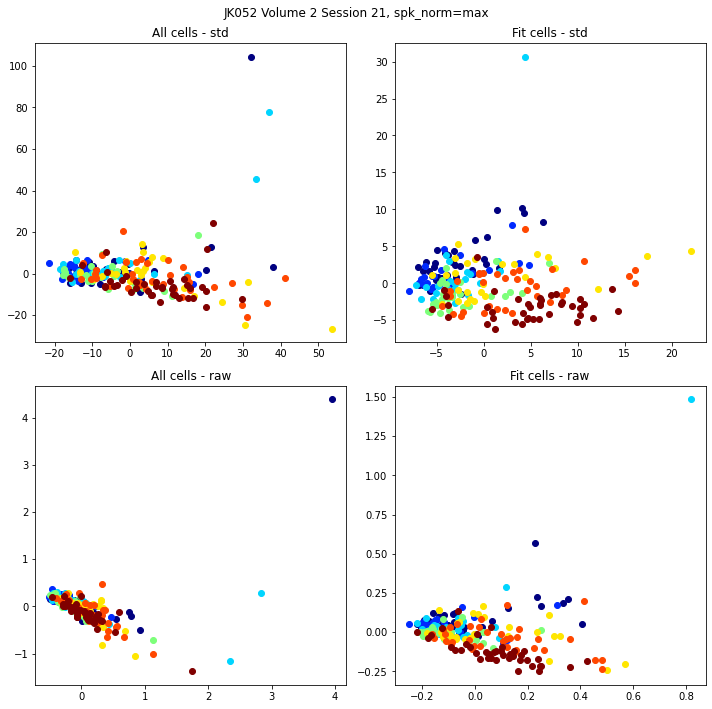

In [68]:
mi = 5
mouse = mice[mi]
volume = 2
post_touch_frames=1
top_plane = 1 if volume == 1 else 5
spk_norms = ['none', 'std', 'max']
pcs=[0,1]
for session in test_sessions[mi]:
    for spk_norm in spk_norms:
        fig, ax = plt.subplots(2,2, figsize=(10,10))
        per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
            get_touch_response_xr_varexp_threshold(mouse, top_plane, session, touch_window='all',
                                                   spk_norm=spk_norm, varexp_threshold=0.05,
                                                   post_touch_frames=post_touch_frames)
        _draw_pca(per_touch_response_xr, per_touch_response_df, ax[0,0], standardization=True, pcs=pcs)
        ax[0,0].set_title('All cells - std')
        _draw_pca(per_touch_response_xr_fit, per_touch_response_df, ax[0,1], standardization=True, pcs=pcs)
        ax[0,1].set_title('Fit cells - std')
        _draw_pca(per_touch_response_xr, per_touch_response_df, ax[1,0], standardization=False, pcs=pcs)
        ax[1,0].set_title('All cells - raw')
        _draw_pca(per_touch_response_xr_fit, per_touch_response_df, ax[1,1], standardization=False, pcs=pcs)
        ax[1,1].set_title('Fit cells - raw')
        fig.suptitle(f'JK{mouse:03} Volume {volume} Session {session:02}, spk_norm={spk_norm}')
        fig.tight_layout()

# Show all mice and volumes
- Standardize spikes
- Standardize touch responses
- Show both all and fit cells

C:\Users\shires\AppData\Local\Temp/ipykernel_31820/1216717385.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2, figsize=(10,5))


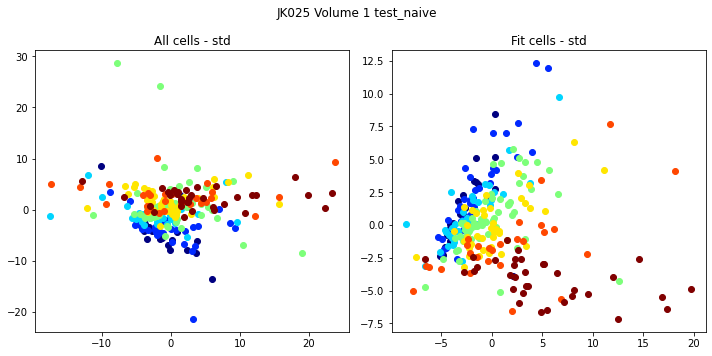

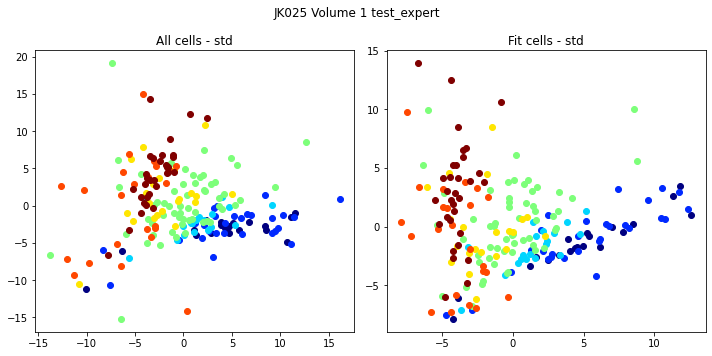

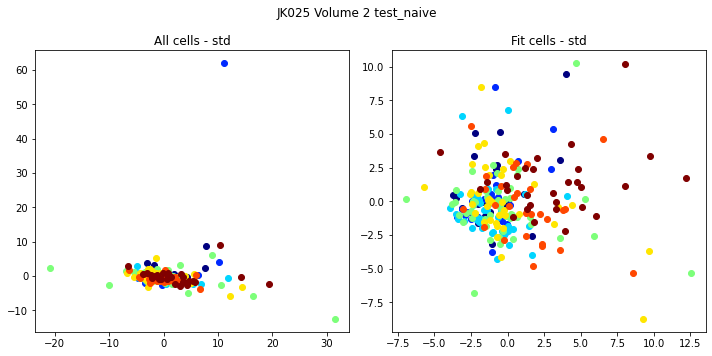

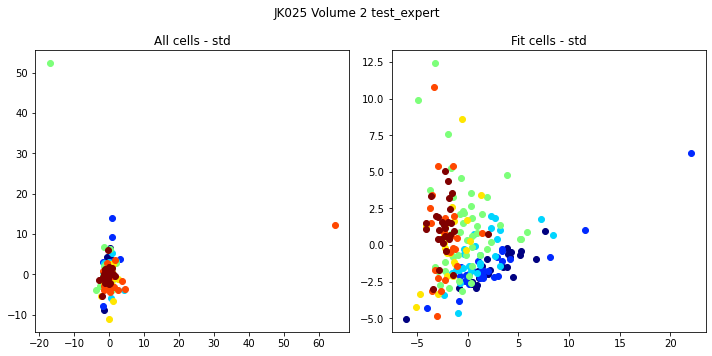

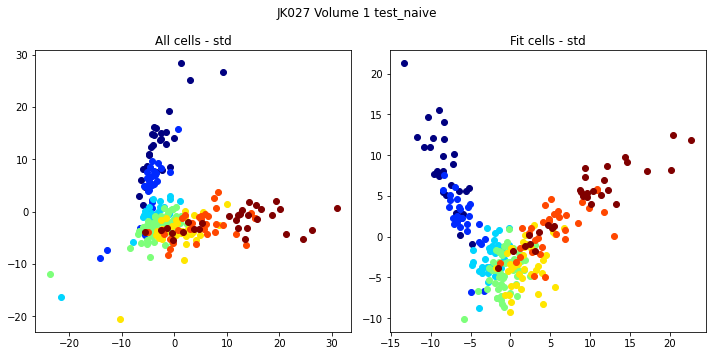

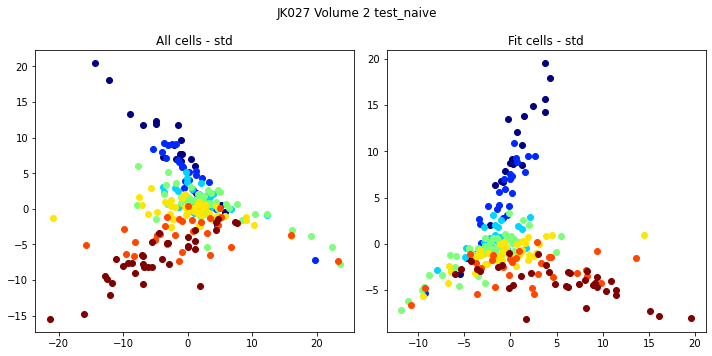

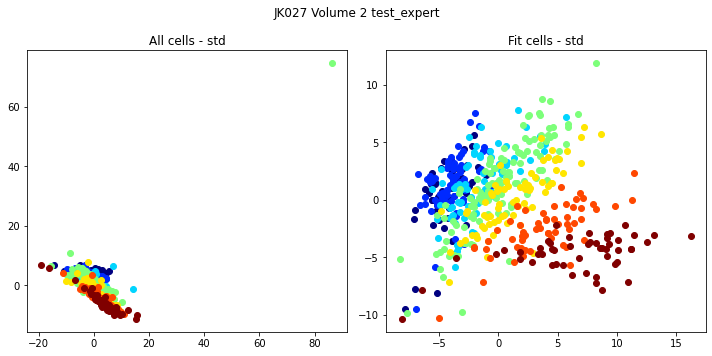

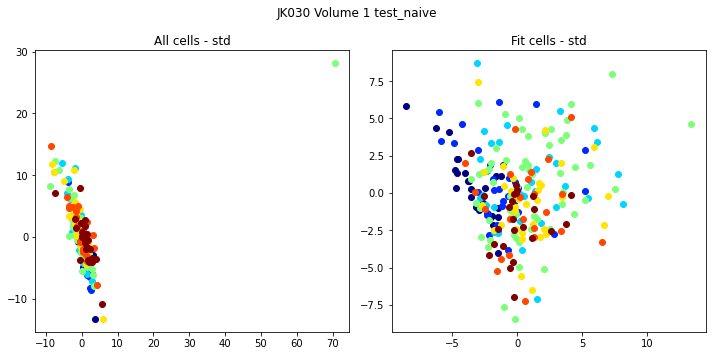

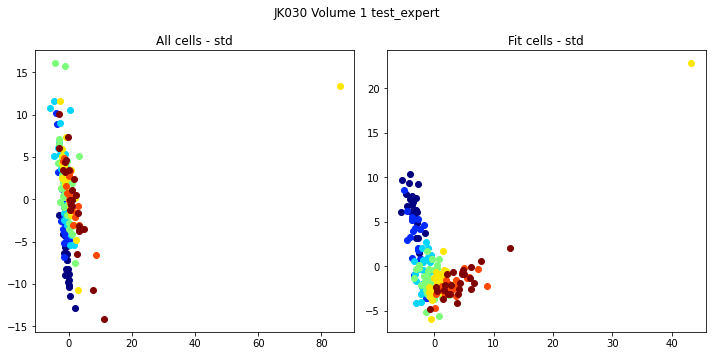

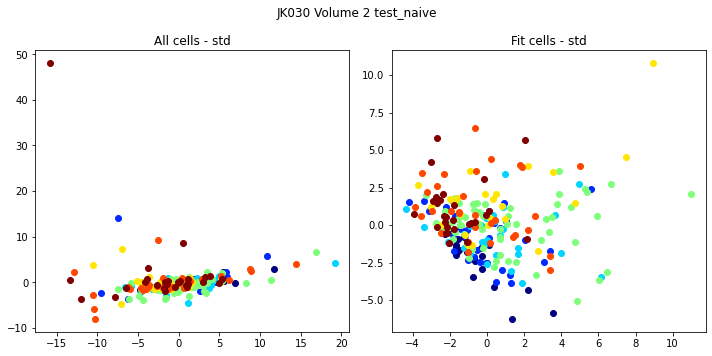

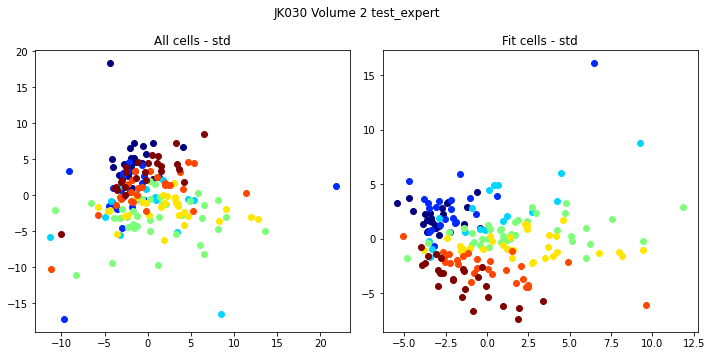

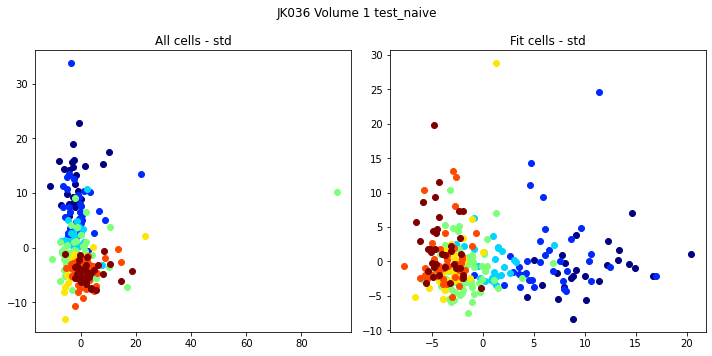

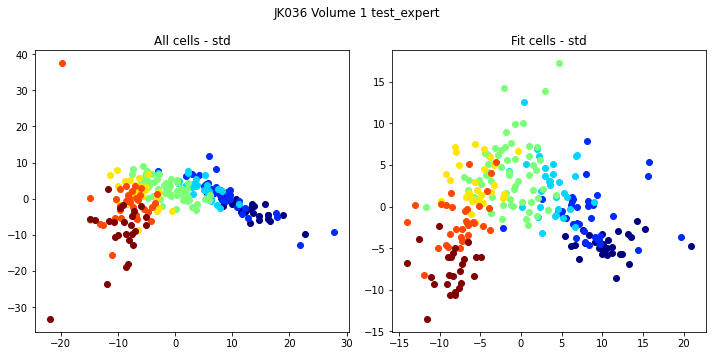

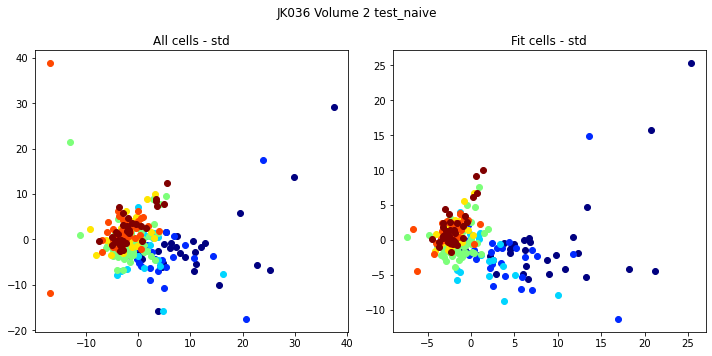

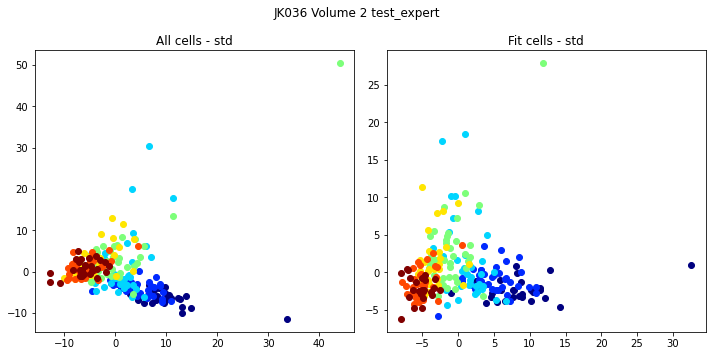

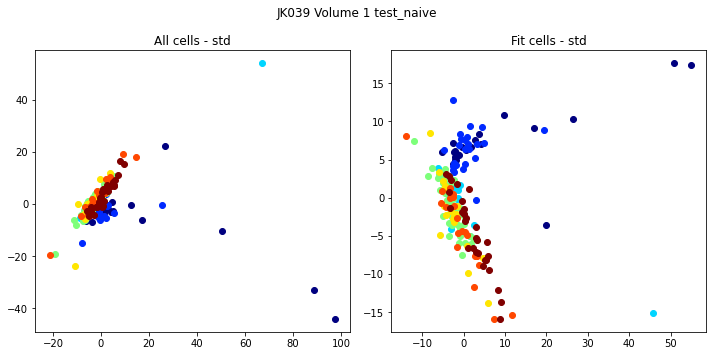

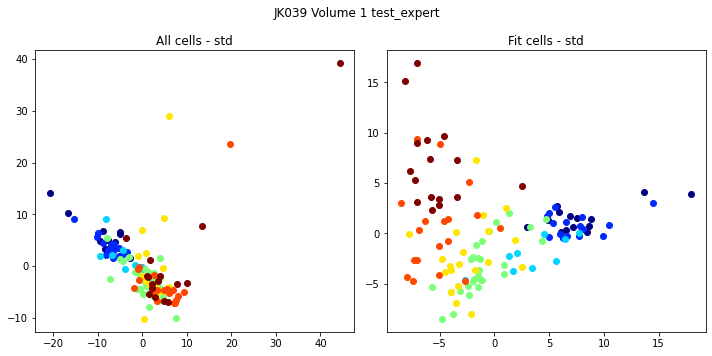

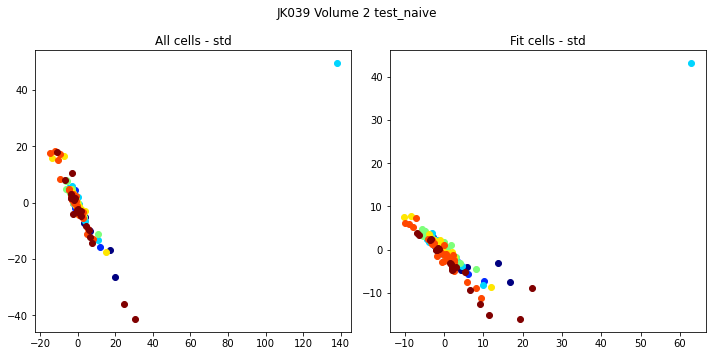

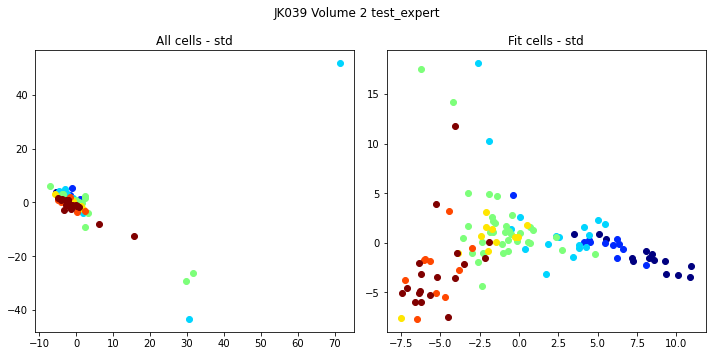

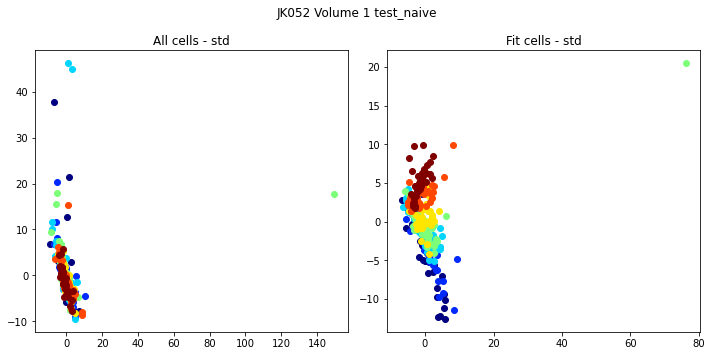

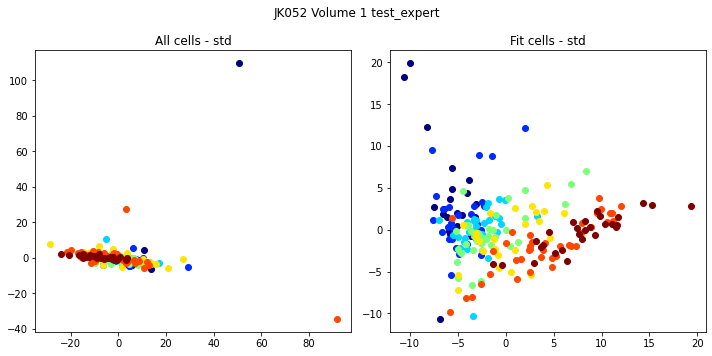

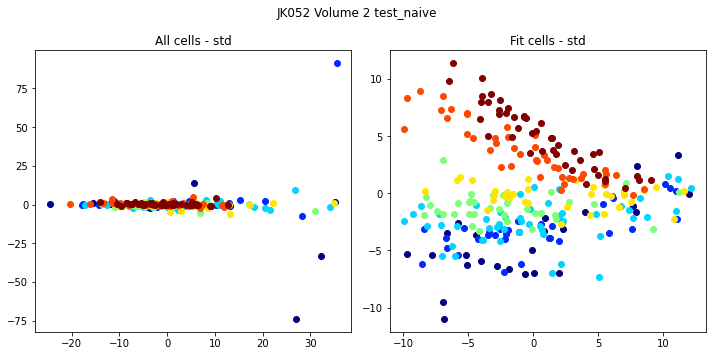

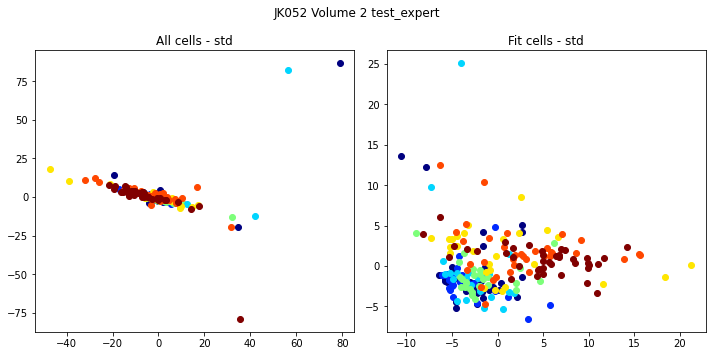

In [31]:
spk_norm = 'std'
varexp_threshold = 0.05
post_touch_frames = 1
standardization = True
touch_window = 'all'
pcs=[0,1]
for mi in range(len(mice)):
    mouse = mice[mi]
    for volume in range(1,3):
        top_plane = 1 if volume == 1 else 5
        for session in test_sessions[mi]:
            session_str = str(session)
            if len(use_mice_df.query('mouse == @mouse and plane == @top_plane and session == @session_str')) > 0:
                fig, ax = plt.subplots(1,2, figsize=(10,5))
                per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
                    get_touch_response_xr_varexp_threshold(mouse, top_plane, session,
                                                        touch_window=touch_window, 
                                                        spk_norm=spk_norm,
                                                        varexp_threshold=varexp_threshold,
                                                        post_touch_frames=post_touch_frames)
                _draw_pca(per_touch_response_xr, per_touch_response_df, 
                        ax[0], standardization=standardization, pcs=pcs)
                ax[0].set_title('All cells - std')
                _draw_pca(per_touch_response_xr_fit, per_touch_response_df, 
                        ax[1], standardization=standardization, pcs=pcs)
                ax[1].set_title('Fit cells - std')
                fig.suptitle(f'JK{mouse:03} Volume {volume} Session {session:02} Touch {touch_window}')
                fig.tight_layout()

# Interim summary
- Neural stretching observed.
- Needs quantification.
- This included all the touches - could be contaminated by rewards.
    - Check those from 'before answer' without miss trials

In [41]:
mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]

In [48]:
mi = 0
volume = 1 # 1 for first volume, 2 for second volume

spk_norm='std'
post_touch_frames=1

mouse = mice[mi]

naive_expert = 0 # 0 for naive, 1 for expert
session = test_sessions[mi][naive_expert]
# top_plane = 1 if volume == 1 else 5
plane = 3

plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

# get merged df
merged_df = get_merged_df(ophys_frametime, behavior_frametime)
# assign pole_moving_up and pole_moving_down to the frames
merged_df = assign_pole_moving_frames(merged_df)

# get spks
norm_spks = get_normalized_spikes(roi_dir, ophys_frametime, merged_df, spk_norm=spk_norm)

merged_df['spks_frame_ind'] = np.arange(norm_spks.shape[1])

# get touch response frames
merged_df = assign_touch_response_frames(merged_df, post_touch_frames=post_touch_frames)

# Get touch response of spks per trial
touch_trial_nums = merged_df[merged_df.touch_response_frame].trialNum.unique()
merged_df = merged_df[merged_df.trialNum.isin(touch_trial_nums)]

In [45]:
merged_df.touch_count.unique()

array([nan,  1.,  2.,  3.,  4.])

In [56]:
for tn in touch_trial_nums:
    trial_df = merged_df[merged_df.trialNum==tn]
    total_touch = np.nansum(trial_df.touch_count.values)
    before_answer_touch = np.nansum(trial_df.before_answer_touch_count.values)
    after_answer_touch = np.nansum(trial_df.after_answer_touch_count.values)
    if total_touch < before_answer_touch + after_answer_touch:
        print(tn)


## There are cases where touch counts are different across planes
- when touch window is limited to before answer or after answer
- See the proportion of this occurrence.
- More problem with 0 and 1

In [113]:
def touch_num_stats_across_planes(mouse, session, top_plane, touch_window='before_answer', spk_norm='std', post_touch_frames=1):
    planes = range(top_plane, top_plane + 4)
    temp_dfs = []
    for plane in planes:
        _, per_touch_response_df_plane = \
            get_touch_response(mouse, session, plane, touch_window=touch_window,
                               spk_norm=spk_norm, post_touch_frames=post_touch_frames)
        temp_dfs.append(per_touch_response_df_plane)
    all_trialNums = temp_dfs[0].trialNum.unique()
    intersect_trialNums = all_trialNums.copy()
    for i in range(1,len(temp_dfs)):
        all_trialNums = np.union1d(all_trialNums, temp_dfs[i].trialNum.unique())
        intersect_trialNums = np.intersect1d(intersect_trialNums, temp_dfs[i].trialNum.unique())
    prop_IOU = len(intersect_trialNums) / len(all_trialNums)
    intersect_df = temp_dfs[0].query('trialNum in @intersect_trialNums').sort_values('trialNum').reset_index(drop=True)
    intersect_df = intersect_df[['trialNum', 'num_touch']]
    for i in range(1,len(temp_dfs)):
        intersect_df = pd.merge(intersect_df, 
                                temp_dfs[i].query('trialNum in @intersect_trialNums').sort_values('trialNum').reset_index(
                                    drop=True)[['trialNum', 'num_touch']],
                                on='trialNum', how='inner', suffixes=('', f'_{i}'))

    num_touch_array = intersect_df.filter(like='num_touch').values
    len_same_touch_num = len(np.where(np.all(num_touch_array == num_touch_array[:,0][:,None], axis=1))[0])
    prop_same_touch_num = len_same_touch_num / len(intersect_df)
    return len(intersect_trialNums), prop_IOU, prop_same_touch_num

In [121]:
volume_df = use_mice_df.query('plane == 1 or plane == 5')
all_num_all_plane_touch_trials = []
all_prop_IOU_touch_trials = []
all_prop_same_touch_num = []
from tqdm.notebook import tqdm
for _, row in tqdm(volume_df.iterrows()):
    mouse = row.mouse
    session = int(row.session)
    top_plane = int(row.plane)
    num_all_plane_touch_trials, prop_IOU_touch_trials, prop_same_touch_num = touch_num_stats_across_planes(mouse, session, top_plane)
    all_num_all_plane_touch_trials.append(num_all_plane_touch_trials)
    all_prop_IOU_touch_trials.append(prop_IOU_touch_trials)
    all_prop_same_touch_num.append(prop_same_touch_num)




0it [00:00, ?it/s]

In [123]:
np.mean(all_prop_IOU_touch_trials)

0.956021821493588

In [124]:
np.mean(all_prop_same_touch_num)

0.27440094563490186

C:\Users\shires\AppData\Local\Temp/ipykernel_31820/2225839493.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2, figsize=(10,5))


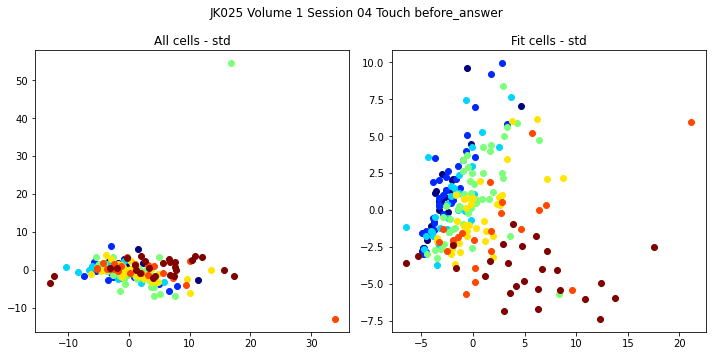

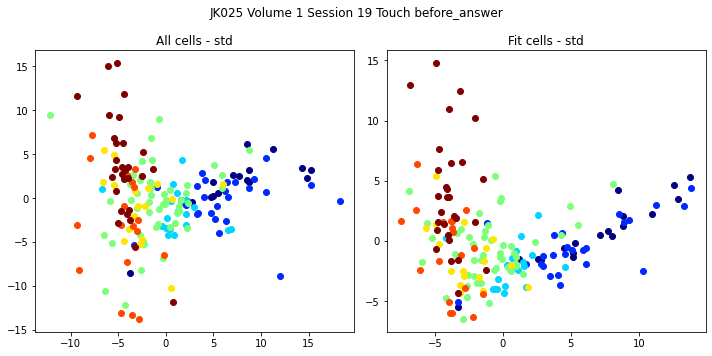

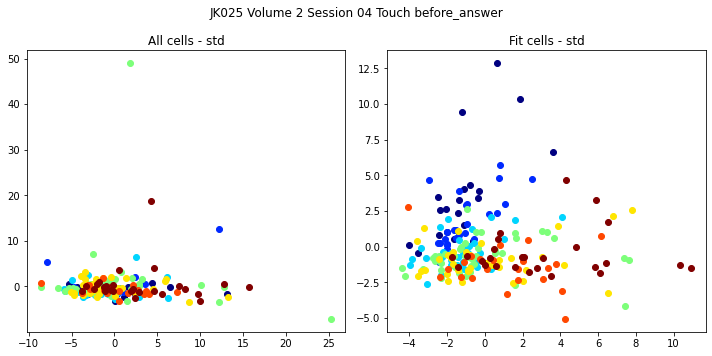

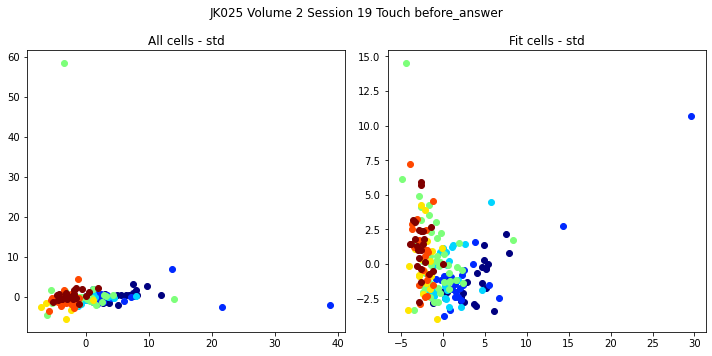

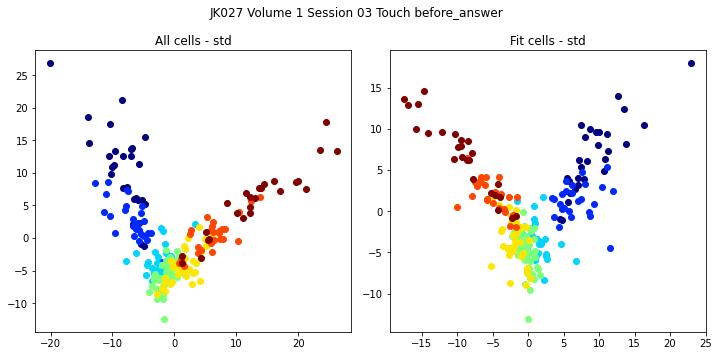

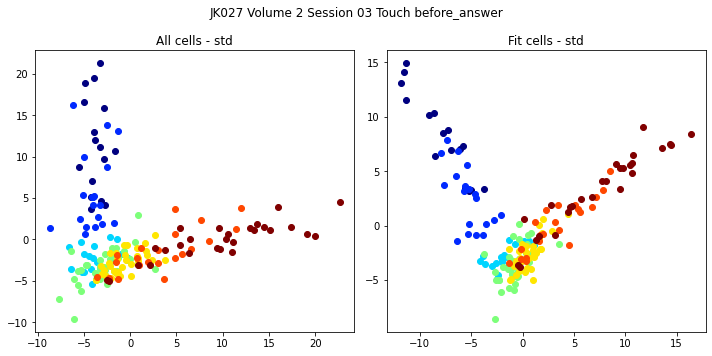

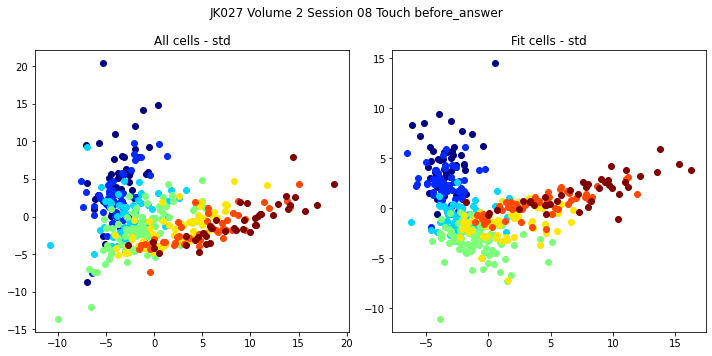

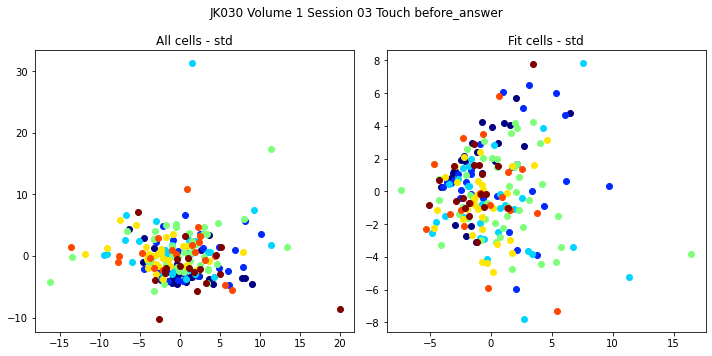

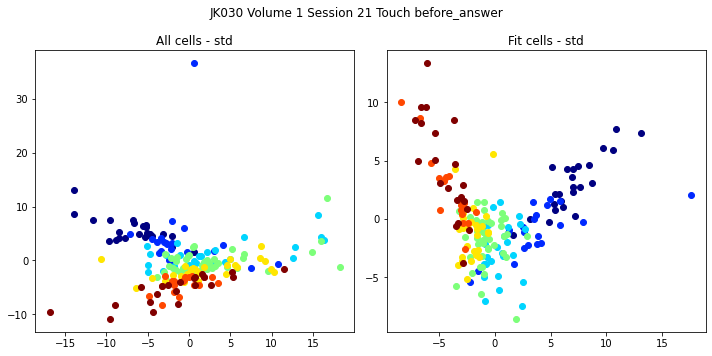

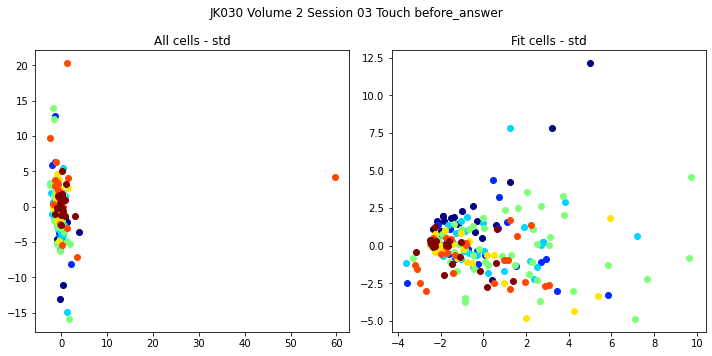

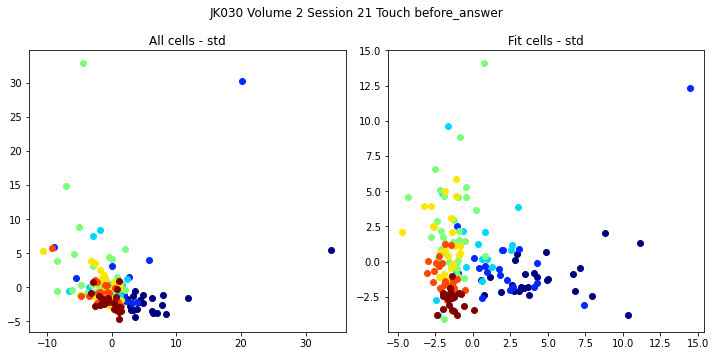

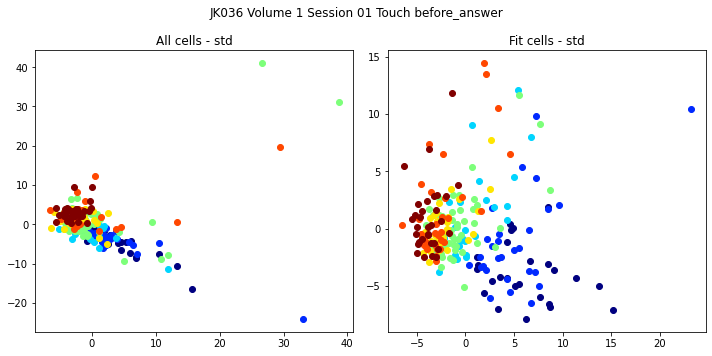

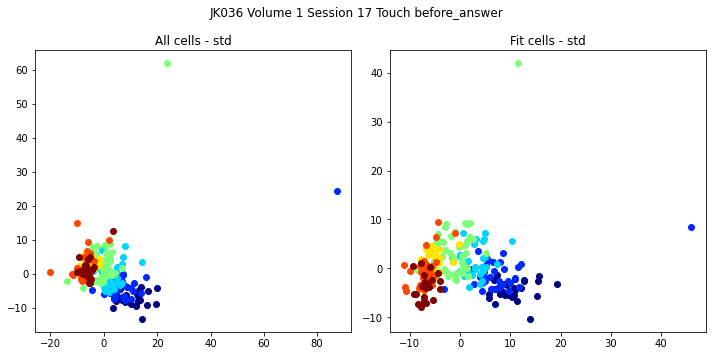

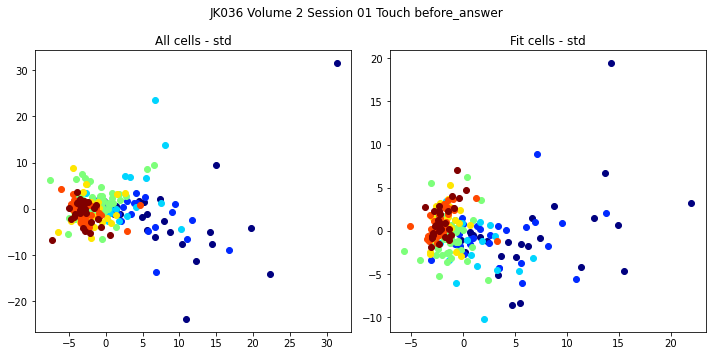

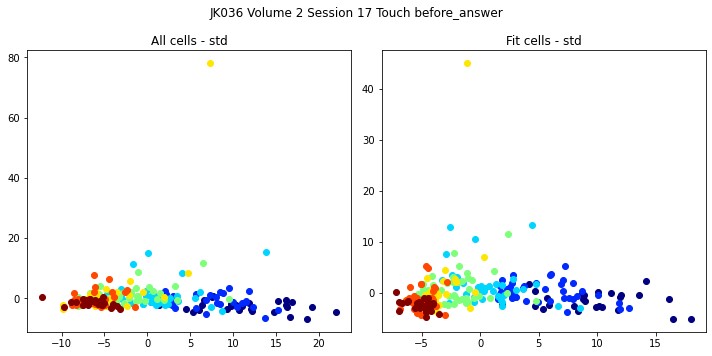

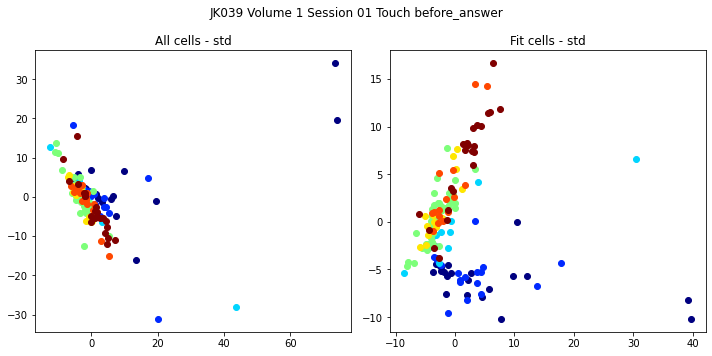

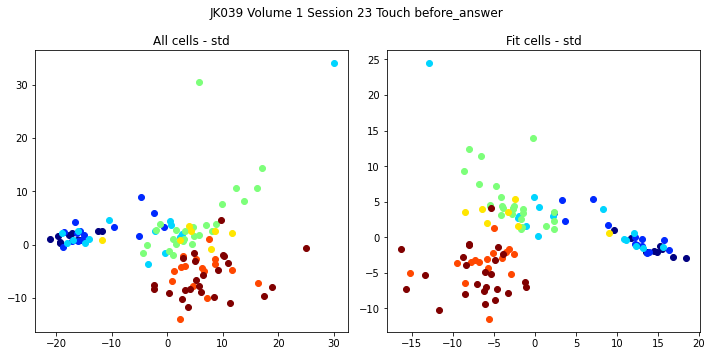

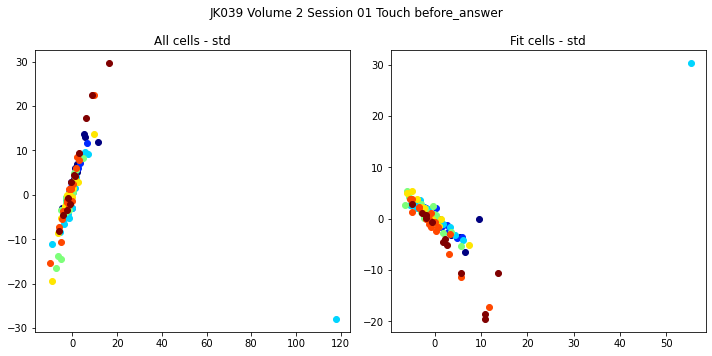

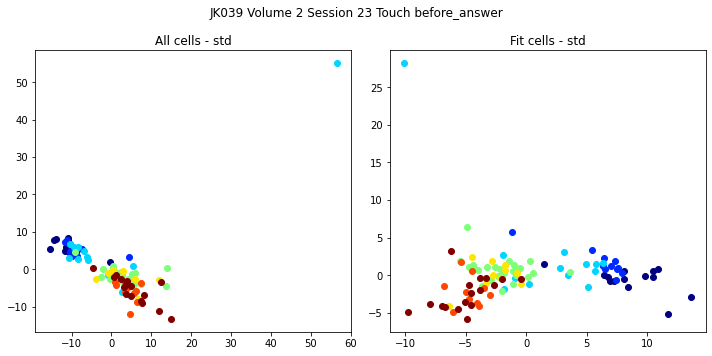

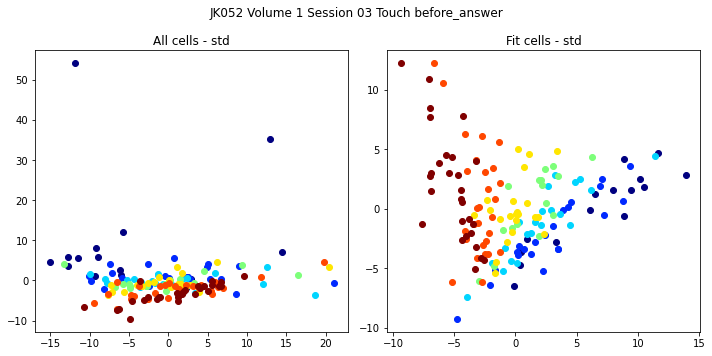

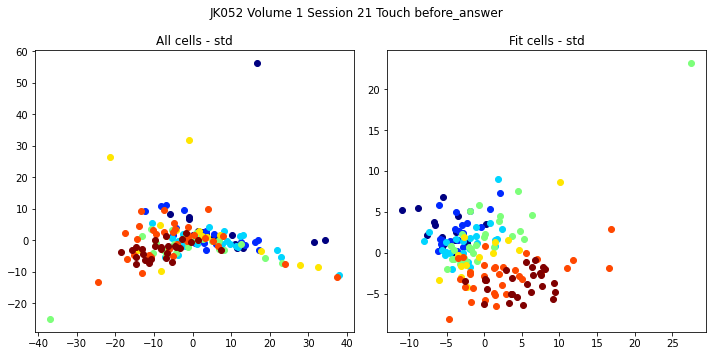

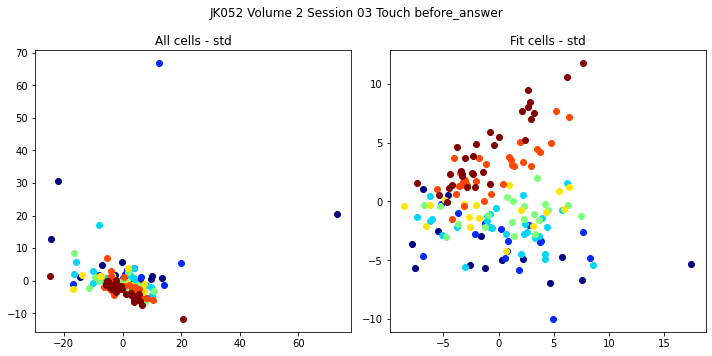

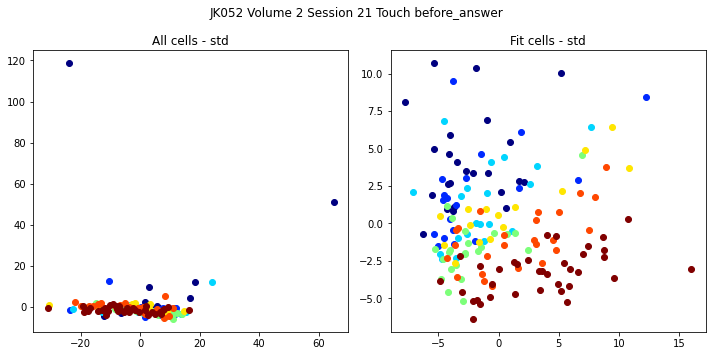

In [133]:
spk_norm = 'std'
varexp_threshold = 0.05
post_touch_frames = 1
standardization = True
touch_window = 'before_answer'
pcs=[0,1]
for mi in range(len(mice)):
    mouse = mice[mi]
    for volume in range(1,3):
        top_plane = 1 if volume == 1 else 5
        for session in test_sessions[mi]:
            session_str = str(session)
            if len(use_mice_df.query('mouse == @mouse and plane == @top_plane and session == @session_str')) > 0:
                fig, ax = plt.subplots(1,2, figsize=(10,5))
                per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
                    get_touch_response_xr_varexp_threshold(mouse, top_plane, session,
                                                        touch_window=touch_window, 
                                                        spk_norm=spk_norm,
                                                        varexp_threshold=varexp_threshold,
                                                        post_touch_frames=post_touch_frames)
                _draw_pca(per_touch_response_xr, per_touch_response_df, 
                        ax[0], standardization=standardization, pcs=pcs)
                ax[0].set_title('All cells - std')
                _draw_pca(per_touch_response_xr_fit, per_touch_response_df, 
                        ax[1], standardization=standardization, pcs=pcs)
                ax[1].set_title('Fit cells - std')
                fig.suptitle(f'JK{mouse:03} Volume {volume} Session {session:02} Touch {touch_window}')
                fig.tight_layout()

# Quantification
- Define dimension based on total explained variance
- Calcualte distances between 45 and 135
- Discrimination through LDA

In [179]:
per_touch_response_xr.shape

(163, 2517)

In [177]:
per_touch_response_xr_fit.shape

(163, 184)

In [180]:
touch_window='before_answer'
spk_norm='std'
post_touch_frames=1
run_mouse = []
run_volume = []
run_session = []
explained_variances_fit = []
explained_variances_all = []
num_trials = []
num_cells_all = []
num_cells_fit = []
angles = np.arange(45, 150, 15)
for mi in range(len(mice)):
    mouse = mice[mi]
    for volume in range(1,3):
        top_plane = 1 if volume == 1 else 5
        for session in test_sessions[mi]:
            session_str = str(session)
            if len(use_mice_df.query('mouse == @mouse and plane == @top_plane and session == @session_str')) > 0:
                per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
                    get_touch_response_xr_varexp_threshold(mouse, top_plane, session,
                                                        touch_window=touch_window, 
                                                        spk_norm=spk_norm,
                                                        varexp_threshold=varexp_threshold,
                                                        post_touch_frames=post_touch_frames)
                num_cells_all.append(per_touch_response_xr.shape[1])
                num_cells_fit.append(per_touch_response_xr_fit.shape[1])
                pca = PCA()
                pca.fit(per_touch_response_xr_fit.values)
                explained_variances_fit.append(pca.explained_variance_ratio_)
                pca = PCA()
                pca.fit(per_touch_response_xr.values)
                explained_variances_all.append(pca.explained_variance_ratio_)

                temp_num_trials = []
                for angle in angles:
                    temp_num_trials.append(len(per_touch_response_df.query('pole_angle == @angle')))
                num_trials.append(temp_num_trials)
                run_mouse.append(mouse)
                run_volume.append(volume)
                run_session.append(session)
expvar_results = pd.DataFrame({'mouse': run_mouse, 'volume': run_volume, 'session': run_session,
                                 'explained_variances_fit': explained_variances_fit,
                                 'explained_variances_all': explained_variances_all,
                                 'num_trials': num_trials,
                                 'num_cells_fit': num_cells_fit,
                                 'num_cells_all': num_cells_all,
                                 })
# Takes about 6 min


In [277]:
results_dir = Path(r'E:\TPM\JK\h5\results\neural_stretching\lda_performances')
expvar_results.to_pickle(results_dir / 'explained_variances_expert_test_sessions.pkl')

In [181]:
expvar_results

mouse  volume  session                            explained_variances_fit  \
0      25       1        4  [0.12491689, 0.07575641, 0.06009612, 0.0465507...   
1      25       1       19  [0.17052875, 0.07504089, 0.063146904, 0.042332...   
2      25       2        4  [0.12047603, 0.08542377, 0.06562399, 0.0547582...   
3      25       2       19  [0.17648093, 0.08719673, 0.0642958, 0.04843358...   
4      27       1        3  [0.17410862, 0.11494908, 0.071352825, 0.039924...   
5      27       2        3  [0.14968415, 0.11527021, 0.05620027, 0.0390460...   
6      27       2        8  [0.12955205, 0.08415257, 0.05526586, 0.0362705...   
7      30       1        3  [0.14300673, 0.08057174, 0.060672026, 0.049000...   
8      30       1       21  [0.1360629, 0.096496195, 0.06713817, 0.0567118...   
9      30       2        3  [0.16106747, 0.09631289, 0.084278345, 0.063924...   
10     30       2       21  [0.12492649, 0.09874886, 0.060904786, 0.050096...   
11     36       1        1  [0.11572212, 0.06792896, 0.05620689, 0.0472397...   
12     36       1       17  [0.19300833, 0.102061614, 0.056177452, 0.04470...   
13     36       2        1  [0.16339962, 0.07252937, 0.04794069, 0.0434059...   
14     36       2       17  [0.15349773, 0.08311415, 0.048668787, 0.041486...   
15     39       1        1  [0.20130977, 0.07123021, 0.053221937, 0.048497...   
16     39       1       23  [0.19371429, 0.09951751, 0.04887741, 0.0364795...   
17     39       2        1  [0.3488492, 0.07168821, 0.050801434, 0.0312533...   
18     39       2       23  [0.1434357, 0.11987145, 0.05738901, 0.04303808...   
19     52       1        3  [0.14318015, 0.06804343, 0.058373064, 0.050991...   
20     52       1       21  [0.17338823, 0.11708937, 0.06948998, 0.0625911...   
21     52       2        3  [0.10269994, 0.078068756, 0.051901463, 0.04462...   
22     52       2       21  [0.10454575, 0.100293376, 0.07384651, 0.046476...   

                              explained_variances_all  \
0   [0.077843845, 0.048517965, 0.04006753, 0.03689...   
1   [0.10289713, 0.051023647, 0.042324588, 0.03390...   
2   [0.07065357, 0.047845397, 0.044710793, 0.03809...   
3   [0.078365274, 0.053452577, 0.042719964, 0.0382...   
4   [0.12464934, 0.087043956, 0.0560178, 0.0311466...   
5   [0.09123282, 0.07719153, 0.04395296, 0.0350227...   
6   [0.061491102, 0.041020975, 0.039561145, 0.0323...   
7   [0.06072753, 0.03983328, 0.036540024, 0.030073...   
8   [0.078543715, 0.06642425, 0.051133208, 0.04048...   
9   [0.1019748, 0.048773635, 0.03654269, 0.0281583...   
10  [0.072020724, 0.052763823, 0.04971655, 0.04138...   
11  [0.07108041, 0.062633276, 0.048143823, 0.04363...   
12  [0.14821537, 0.076938115, 0.0658331, 0.0352639...   
13  [0.0883051, 0.046001658, 0.03677394, 0.0313571...   
14  [0.078076385, 0.059430413, 0.036682375, 0.0289...   
15  [0.16489173, 0.051493898, 0.04942095, 0.038641...   
16  [0.1336527, 0.07534964, 0.04540711, 0.03833721...   
17  [0.2580851, 0.03815617, 0.03359146, 0.03276507...   
18  [0.114727326, 0.070639476, 0.03578487, 0.03384...   
19  [0.06098509, 0.043696426, 0.041270975, 0.03737...   
20  [0.11764481, 0.053373404, 0.0431564, 0.0372640...   
21  [0.051904697, 0.028898729, 0.028307782, 0.0271...   
22  [0.062786214, 0.05441238, 0.043072384, 0.03836...   

                      num_trials  num_cells_fit  num_cells_all  
0   [23, 35, 31, 51, 35, 22, 26]            154            610  
1   [18, 26, 18, 49, 17, 19, 29]            156            561  
2   [20, 25, 33, 43, 36, 22, 26]             96            539  
3   [26, 26, 24, 44, 20, 20, 25]             92            505  
4   [28, 26, 26, 50, 34, 26, 25]            297            705  
5   [16, 19, 22, 35, 32, 21, 27]            200            518  
6   [50, 60, 61, 91, 59, 47, 41]            138            481  
7   [26, 29, 30, 45, 31, 20, 19]             97            590  
8   [24, 21, 25, 43, 28, 19, 21]            158            580  
9   [26, 25, 26, 51, 21, 24, 21]        

In [191]:
test_sessions

[[4, 19], [3, 8], [3, 21], [1, 17], [1, 23], [3, 21]]

In [195]:
# Is there any systematic difference in the explained variance between the first and second test sessions?
expvar_diff = []
for mi in range(len(mice)):
    mouse = mice[mi]
    sessions = test_sessions[mi]
    for volume in range(1,3):
        expvar_volume = expvar_results.query('mouse == @mouse and volume == @volume')
        if len(expvar_volume) == 2:
            expert_session = sessions[1]
            expvar_expert = np.sum(expvar_volume.query('session == @expert_session').explained_variances_fit.values[0][:3])
            naive_session = sessions[0]
            expvar_naive = np.sum(expvar_volume.query('session == @naive_session').explained_variances_fit.values[0][:3])
            expvar_diff.append(expvar_expert - expvar_naive)


In [196]:
# Run LDA to discriminate between the angles
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def lda_discriminate_angle(mouse, session, top_plane, touch_window='before_answer',
                            spk_norm='std', varexp_threshold=0.05, post_touch_frames=1):
     per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
          get_touch_response_xr_varexp_threshold(mouse, top_plane, session, touch_window=touch_window,
                                                  spk_norm=spk_norm, varexp_threshold=varexp_threshold,
                                                  post_touch_frames=post_touch_frames)
     X = per_touch_response_xr_fit.values
     y = per_touch_response_df.pole_angle.values
     
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
     lda = LDA()
     lda.fit(X_train, y_train)
     y_pred = lda.predict(X_test)
     accuracy = accuracy_score(y_test, y_pred)
     return accuracy

[0.04794711,
 0.05644965,
 -0.052184135,
 0.015446782,
 -0.05707857,
 0.1113894,
 0.0014109612,
 0.01634729,
 -0.15064266,
 0.09037095,
 0.04601547]

## Test LDA for angle discrimination
- Run it against increasing PCs to test the upper limit

In [197]:
mouse = 25
session = 4
top_plane = 1

num_groups_LDA = 4
per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    get_touch_response_xr_varexp_threshold(mouse, top_plane, session, touch_window=touch_window,
                                            spk_norm=spk_norm, varexp_threshold=varexp_threshold,
                                            post_touch_frames=post_touch_frames)


In [6]:
def random_split(inds, num_split=4):
    inds = np.random.choice(inds, len(inds), replace=False)
    split = []
    group_ids = np.arange(len(inds)) % num_split
    for gi in range(num_split):
        split.append(inds[group_ids==gi])
    return split


def stratify_random_split(inds, stratify_class, num_splits=4):
    assert len(inds) == len(stratify_class)
    classes = np.unique(stratify_class)
    num_classes = len(classes)
    ci = 0
    splits = [[] for i in range(num_splits)]
    for ci in range(num_classes):
        class_inds = np.where(stratify_class==classes[ci])[0]
        split_temp = random_split(inds[class_inds], num_split=num_splits)
        for gi in range(num_splits):
            splits[gi] = np.concatenate([splits[gi], split_temp[gi]])
    return splits


def lda_cross_validate(X, y, splits_inds):
    num_splits = len(splits_inds)
    accuracies = []
    for si in range(num_splits):
        test_inds = splits_inds[si]
        train_inds = np.setdiff1d(np.arange(len(y)), test_inds)
        X_train = X[train_inds,:]
        y_train = y[train_inds]
        X_test = X[test_inds.astype(int),:]
        y_test = y[test_inds.astype(int)]
        lda = LDA()
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return accuracies


def get_lda_accuracies(X, y, num_split=4, num_repeat=30):    
    all_mean_accuracy = []
    for ri in range(num_repeat):
        splits_inds = stratify_random_split(np.arange(len(y)), y, num_splits=num_split)
        accuracy = np.mean(lda_cross_validate(X, y, splits_inds))        
        all_mean_accuracy.append(accuracy)
    return np.mean(all_mean_accuracy)


def get_shuffle_lda_accuracies(X, y, num_split=4, num_shuffle=100):
    splits_inds = stratify_random_split(np.arange(len(y)), y, num_splits=num_split)    
    shuffle_accuracies = []
    for si in range(num_shuffle):
        shuffle_y = np.random.permutation(y)
        shuffle_accuracies.append(lda_cross_validate(X, shuffle_y, splits_inds))
    shuffle_accuracies = np.array(shuffle_accuracies)
    mean_shuffle_accuracy = np.mean([np.mean(sa) for sa in shuffle_accuracies])
    
    return mean_shuffle_accuracy

In [270]:
get_lda_accuracies(per_touch_response_xr_fit, per_touch_response_df.pole_angle.values)

0.2339133785698187

In [271]:
per_touch_response_xr_fit.dims

('trialNum', 'cell_id')

In [272]:
pca = PCA()
pca.fit_transform(per_touch_response_xr_fit)



array([[ 6.6598499e-01,  2.0783486e+00,  3.9387674e+00, ...,
        -2.0046204e-02, -2.4104025e-02, -3.6746762e-03],
       [-3.9306763e-01, -1.4261408e+00,  1.7776155e+00, ...,
        -9.2961323e-03,  1.2083054e-02,  5.8646265e-02],
       [-5.0933161e+00, -2.7730618e+00,  2.4347559e-01, ...,
         3.1252261e-02, -9.1356300e-02,  2.0446757e-02],
       ...,
       [ 2.0198090e+01,  3.4095047e+00, -6.9098635e+00, ...,
         1.5418325e-02,  1.0582792e-02, -2.3319401e-02],
       [ 2.6441872e+00, -8.2332456e-01,  4.7147399e-01, ...,
        -1.1564358e-01,  1.7684000e-03,  3.6373086e-02],
       [ 1.6722120e+00, -2.6169827e+00,  6.2911850e-01, ...,
         1.5762283e-02,  9.3864073e-04,  3.7647065e-02]], dtype=float32)

In [273]:
pca.components_.shape

(154, 154)

In [274]:
dim_nums = [*np.arange(3, 11), *np.arange(20, pca.components_.shape[0], 10)]
lda_performances = []
for di in dim_nums:
    X_pca = pca.transform(per_touch_response_xr_fit)[:,:di]
    lda_performances.append(get_lda_accuracies(X_pca, per_touch_response_df.pole_angle.values))

In [275]:
lda_performances

[0.5277901534176889,
 0.5297581820084355,
 0.5164497408158666,
 0.5058915089024115,
 0.5158808638397888,
 0.523560401171963,
 0.5103357722399304,
 0.528035150841946,
 0.5177023970507743,
 0.5217777053350076,
 0.5179043312727389,
 0.5071604647606168,
 0.4897272127241702,
 0.49836450384751607,
 0.4891101411829099,
 0.47393438697317997,
 0.4592582866479925,
 0.430916461412151,
 0.3730058115200103,
 0.3321516106442577,
 0.2821023093145304,
 0.26004076918123575]

### Better LDA performance with lower dimensions
- Run all test sessions in parallel (calculate_lda_test_sessions.py)

In [8]:
results_dir = Path(r'E:\TPM\JK\h5\results\neural_stretching\lda_performances')
expvar_results = pd.read_pickle(results_dir / 'explained_variances_expert_test_sessions.pkl')


In [282]:
row = expvar_results.iloc[0]
mouse = row.mouse
volume = row.volume
session = row.session
lda_results = np.load(results_dir / f'JK{mouse:03}_volume{volume}_S{session:02d}_lda_performances_{touch_window}.npy',
                      allow_pickle=True).item()

Text(0, 0.5, 'LDA performance')

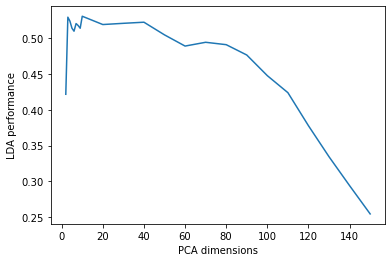

In [286]:
fig, ax = plt.subplots()
ax.plot(lda_results['dim_nums'], lda_results['lda_performances'])
ax.set_xlabel('PCA dimensions')
ax.set_ylabel('LDA performance')

In [291]:
lda_results['dim_nums']

[2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]

In [292]:
# Divide into upper and lower volumes, and naive and expert sessions
# Interpolate PCA dimensions to calculate mean and SEM
# Import functions for 1d interpolation
from scipy.interpolate import interp1d
ref_dims = [*np.arange(2,11), *np.arange(20, 51, 10)]
lda_upper_naive = []
lda_upper_expert = []
lda_lower_naive = []
lda_lower_expert = []
for i, row in expvar_results.iterrows():
    mouse = row.mouse
    volume = row.volume
    session = row.session
    lda_results = np.load(results_dir / f'JK{mouse:03}_volume{volume}_S{session:02d}_lda_performances_{touch_window}.npy',
                          allow_pickle=True).item()
    # interpolate dims and lda_performances
    f = interp1d(lda_results['dim_nums'], lda_results['lda_performances'])
    interp_lda_performances = f(ref_dims)
    if volume == 1:
        if session < 5:
            lda_upper_naive.append(interp_lda_performances)
        else:
            lda_upper_expert.append(interp_lda_performances)
    else:
        if session < 5:
            lda_lower_naive.append(interp_lda_performances)
        else:
            lda_lower_expert.append(interp_lda_performances)

Text(0, 0.5, 'LDA performance')

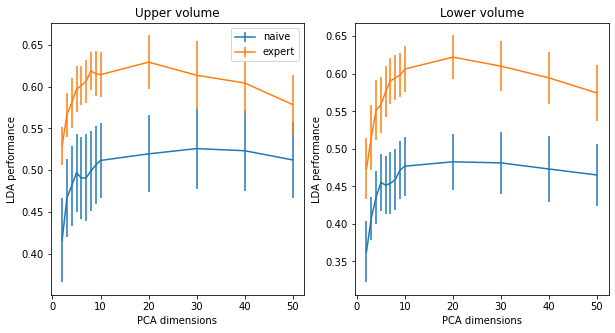

In [294]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].errorbar(ref_dims, np.mean(lda_upper_naive, axis=0), np.std(lda_upper_naive, axis=0)/np.sqrt(len(lda_upper_naive)), label='naive')
ax[0].errorbar(ref_dims, np.mean(lda_upper_expert, axis=0), np.std(lda_upper_expert, axis=0)/np.sqrt(len(lda_upper_expert)), label='expert')
ax[0].set_title('Upper volume')
ax[0].set_xlabel('PCA dimensions')
ax[0].set_ylabel('LDA performance')
ax[0].legend()
ax[1].errorbar(ref_dims, np.mean(lda_lower_naive, axis=0), np.std(lda_lower_naive, axis=0)/np.sqrt(len(lda_lower_naive)), label='naive')
ax[1].errorbar(ref_dims, np.mean(lda_lower_expert, axis=0), np.std(lda_lower_expert, axis=0)/np.sqrt(len(lda_lower_expert)), label='expert')
ax[1].set_title('Lower volume')
ax[1].set_xlabel('PCA dimensions')
ax[1].set_ylabel('LDA performance')


In [297]:
ve_upper_naive = []
ve_upper_expert = []
ve_lower_naive = []
ve_lower_expert = []
for i, row in expvar_results.iterrows():
    volume = row.volume
    session = row.session
    
    ve_fit = row.explained_variances_fit
    if volume == 1:
        if session < 5:
            ve_upper_naive.append(np.cumsum(ve_fit[:20]))
        else:
            ve_upper_expert.append(np.cumsum(ve_fit[:20]))
    else:
        if session < 5:
            ve_lower_naive.append(np.cumsum(ve_fit[:20]))
        else:
            ve_lower_expert.append(np.cumsum(ve_fit[:20]))

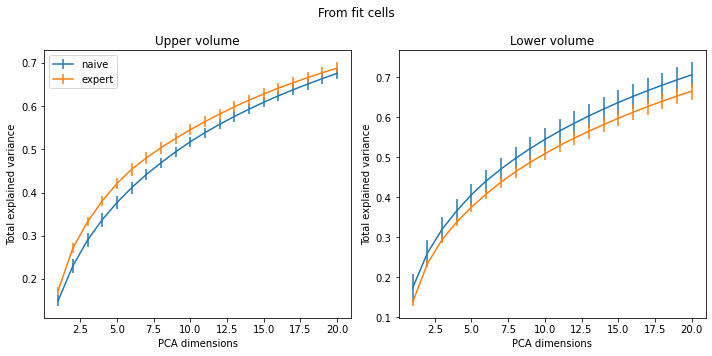

In [300]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].errorbar(range(1,21), np.mean(ve_upper_naive, axis=0), np.std(ve_upper_naive, axis=0)/np.sqrt(len(ve_upper_naive)), label='naive')
ax[0].errorbar(range(1,21), np.mean(ve_upper_expert, axis=0), np.std(ve_upper_expert, axis=0)/np.sqrt(len(ve_upper_expert)), label='expert')
ax[0].set_title('Upper volume')
ax[0].set_xlabel('PCA dimensions')
ax[0].set_ylabel('Total explained variance')
ax[0].legend()
ax[1].errorbar(range(1,21), np.mean(ve_lower_naive, axis=0), np.std(ve_lower_naive, axis=0)/np.sqrt(len(ve_lower_naive)), label='naive')
ax[1].errorbar(range(1,21), np.mean(ve_lower_expert, axis=0), np.std(ve_lower_expert, axis=0)/np.sqrt(len(ve_lower_expert)), label='expert')
ax[1].set_title('Lower volume')
ax[1].set_xlabel('PCA dimensions')
ax[1].set_ylabel('Total explained variance')
fig.suptitle('From fit cells')
fig.tight_layout()


In [304]:
expvar_results[~((expvar_results.mouse==27) & (expvar_results.volume==1))]

mouse  volume  session                            explained_variances_fit  \
0      25       1        4  [0.12491689, 0.07575641, 0.06009612, 0.0465507...   
1      25       1       19  [0.17052875, 0.07504089, 0.063146904, 0.042332...   
2      25       2        4  [0.12047603, 0.08542377, 0.06562399, 0.0547582...   
3      25       2       19  [0.17648093, 0.08719673, 0.0642958, 0.04843358...   
5      27       2        3  [0.14968415, 0.11527021, 0.05620027, 0.0390460...   
6      27       2        8  [0.12955205, 0.08415257, 0.05526586, 0.0362705...   
7      30       1        3  [0.14300673, 0.08057174, 0.060672026, 0.049000...   
8      30       1       21  [0.1360629, 0.096496195, 0.06713817, 0.0567118...   
9      30       2        3  [0.16106747, 0.09631289, 0.084278345, 0.063924...   
10     30       2       21  [0.12492649, 0.09874886, 0.060904786, 0.050096...   
11     36       1        1  [0.11572212, 0.06792896, 0.05620689, 0.0472397...   
12     36       1       17  [0.19300833, 0.102061614, 0.056177452, 0.04470...   
13     36       2        1  [0.16339962, 0.07252937, 0.04794069, 0.0434059...   
14     36       2       17  [0.15349773, 0.08311415, 0.048668787, 0.041486...   
15     39       1        1  [0.20130977, 0.07123021, 0.053221937, 0.048497...   
16     39       1       23  [0.19371429, 0.09951751, 0.04887741, 0.0364795...   
17     39       2        1  [0.3488492, 0.07168821, 0.050801434, 0.0312533...   
18     39       2       23  [0.1434357, 0.11987145, 0.05738901, 0.04303808...   
19     52       1        3  [0.14318015, 0.06804343, 0.058373064, 0.050991...   
20     52       1       21  [0.17338823, 0.11708937, 0.06948998, 0.0625911...   
21     52       2        3  [0.10269994, 0.078068756, 0.051901463, 0.04462...   
22     52       2       21  [0.10454575, 0.100293376, 0.07384651, 0.046476...   

                              explained_variances_all  \
0   [0.077843845, 0.048517965, 0.04006753, 0.03689...   
1   [0.10289713, 0.051023647, 0.042324588, 0.03390...   
2   [0.07065357, 0.047845397, 0.044710793, 0.03809...   
3   [0.078365274, 0.053452577, 0.042719964, 0.0382...   
5   [0.09123282, 0.07719153, 0.04395296, 0.0350227...   
6   [0.061491102, 0.041020975, 0.039561145, 0.0323...   
7   [0.06072753, 0.03983328, 0.036540024, 0.030073...   
8   [0.078543715, 0.06642425, 0.051133208, 0.04048...   
9   [0.1019748, 0.048773635, 0.03654269, 0.0281583...   
10  [0.072020724, 0.052763823, 0.04971655, 0.04138...   
11  [0.07108041, 0.062633276, 0.048143823, 0.04363...   
12  [0.14821537, 0.076938115, 0.0658331, 0.0352639...   
13  [0.0883051, 0.046001658, 0.03677394, 0.0313571...   
14  [0.078076385, 0.059430413, 0.036682375, 0.0289...   
15  [0.16489173, 0.051493898, 0.04942095, 0.038641...   
16  [0.1336527, 0.07534964, 0.04540711, 0.03833721...   
17  [0.2580851, 0.03815617, 0.03359146, 0.03276507...   
18  [0.114727326, 0.070639476, 0.03578487, 0.03384...   
19  [0.06098509, 0.043696426, 0.041270975, 0.03737...   
20  [0.11764481, 0.053373404, 0.0431564, 0.0372640...   
21  [0.051904697, 0.028898729, 0.028307782, 0.0271...   
22  [0.062786214, 0.05441238, 0.043072384, 0.03836...   

                      num_trials  num_cells_fit  num_cells_all  
0   [23, 35, 31, 51, 35, 22, 26]            154            610  
1   [18, 26, 18, 49, 17, 19, 29]            156            561  
2   [20, 25, 33, 43, 36, 22, 26]             96            539  
3   [26, 26, 24, 44, 20, 20, 25]             92            505  
5   [16, 19, 22, 35, 32, 21, 27]            200            518  
6   [50, 60, 61, 91, 59, 47, 41]            138            481  
7   [26, 29, 30, 45, 31, 20, 19]             97            590  
8   [24, 21, 25, 43, 28, 19, 21]            158            580  
9   [26, 25, 26, 51, 21, 24, 21]             56            514  
10  [25, 22, 16, 37, 26, 24, 22]            111            504  
11  [25, 29, 25, 57, 31, 33, 32]            231           1010  
12  [28, 33, 31, 58, 28, 33, 23]            312 

In [313]:
# Choose 3, 5 and 9 dimensions (~30, 40, and 50% of explained variance, respectively, from fit cells)
# Look at the LDA performances

lda_naive_dim3 = []
lda_naive_dim5 = []
lda_naive_dim9 = []
lda_expert_dim3 = []
lda_expert_dim5 = []
lda_expert_dim9 = []
expvar_comp_df = expvar_results[~((expvar_results.mouse==27) & (expvar_results.volume==1))]
for i, row in expvar_comp_df.iterrows():
    mouse = row.mouse
    volume = row.volume
    session = row.session
    lda_results = np.load(results_dir / f'JK{mouse:03}_volume{volume}_S{session:02d}_lda_performances_{touch_window}.npy',
                          allow_pickle=True).item()
    # interpolate dims and lda_performances
    ind_3 = np.where(np.array(lda_results['dim_nums'])==3)[0][0]
    ind_5 = np.where(np.array(lda_results['dim_nums'])==5)[0][0]
    ind_9 = np.where(np.array(lda_results['dim_nums'])==9)[0][0]
    if session < 5:
        lda_naive_dim3.append(lda_results['lda_performances'][ind_3])
        lda_naive_dim5.append(lda_results['lda_performances'][ind_5])
        lda_naive_dim9.append(lda_results['lda_performances'][ind_9])
    else:
        lda_expert_dim3.append(lda_results['lda_performances'][ind_3])
        lda_expert_dim5.append(lda_results['lda_performances'][ind_5])
        lda_expert_dim9.append(lda_results['lda_performances'][ind_9])

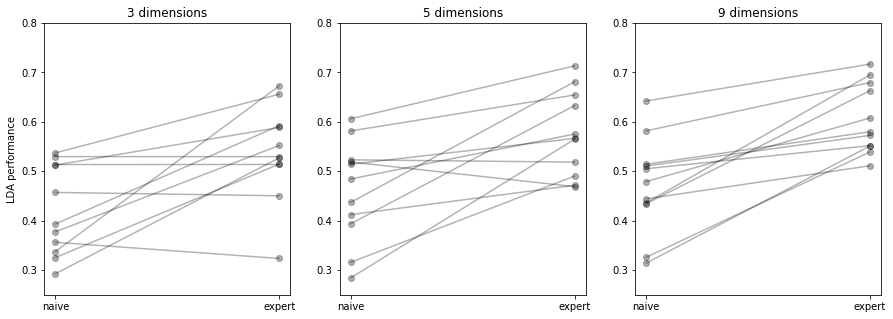

In [320]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i in range(len(lda_naive_dim3)):
    ax[0].plot([0, 1], [lda_naive_dim3[i], lda_expert_dim3[i]], 'o-', color='black', alpha=0.3)
    ax[1].plot([0, 1], [lda_naive_dim5[i], lda_expert_dim5[i]], 'o-', color='black', alpha=0.3)
    ax[2].plot([0, 1], [lda_naive_dim9[i], lda_expert_dim9[i]], 'o-', color='black', alpha=0.3)
ax[0].set_title('3 dimensions')
ax[0].set_ylabel('LDA performance')
ax[1].set_title('5 dimensions')
ax[2].set_title('9 dimensions')
for i in range(3):
    ax[i].set_xticks([0,1])
    ax[i].set_xticklabels(['naive', 'expert'])
    ax[i].set_ylim(0.25, 0.8)


In [323]:
from scipy.stats import ttest_rel
print(ttest_rel(lda_naive_dim3, lda_expert_dim3))
print(ttest_rel(lda_naive_dim5, lda_expert_dim5))
print(ttest_rel(lda_naive_dim9, lda_expert_dim9))


Ttest_relResult(statistic=-3.2415888931479437, pvalue=0.0088455807103417)
Ttest_relResult(statistic=-3.5761822792942373, pvalue=0.005043615764076624)
Ttest_relResult(statistic=-5.3986765992087715, pvalue=0.0003019855171774572)


### Some more things to show 
- confusion matrix
- error angle

# LDA between 45 and 135 degrees only
- Using multiprocessing scripts
- Using only 45 and 135 degree trials
- Apply to all training sessions

# Distance between 45 and 135
- First from test sessions
    - Compare between PCA from 45/135 angles only, with PCA from all the angles
- Across training

In [11]:
touch_window = 'before_answer'
spk_norm = 'std'
varexp_threshold = 0.05
post_touch_frames = 1
row = expvar_comp_df.iloc[0]
mouse = row.mouse
volume = row.volume
session = row.session
top_plane = 1 if volume == 1 else 5
per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    get_touch_response_xr_varexp_threshold(mouse, top_plane, session, touch_window=touch_window,
                                            spk_norm=spk_norm, varexp_threshold=varexp_threshold,
                                            post_touch_frames=post_touch_frames)


In [36]:
def get_distance_45_135(per_touch_response_xr_fit, per_touch_response_df, dim = 9):
    pca = PCA()
    pca.fit_transform(per_touch_response_xr_fit)
    X_pca = pca.transform(per_touch_response_xr_fit)[:,:dim]
    ind_45 = np.where(per_touch_response_df.pole_angle==45)[0]
    ind_135 = np.where(per_touch_response_df.pole_angle==135)[0]
    # full_connected distances
    distances = []
    for ind in ind_45:
        for ind2 in ind_135:
            distances.append(np.linalg.norm(X_pca[ind,:]-X_pca[ind2,:]))
    # Distances from running PCA only with 45 and 135 degrees
    pca2 = PCA()
    response_45_135 = per_touch_response_xr_fit.isel(trialNum=np.union1d(ind_45, ind_135))
    X2_pca = pca2.fit_transform(response_45_135)[:,:dim]
    tn_45 = per_touch_response_df.trialNum.values[ind_45]
    tn_135 = per_touch_response_df.trialNum.values[ind_135]
    x2_ind_45 = np.where(response_45_135.trialNum.isin(tn_45))[0]
    x2_ind_135 = np.where(response_45_135.trialNum.isin(tn_135))[0]
    distances2 = []
    for ind in x2_ind_45:
        for ind2 in x2_ind_135:
            distances2.append(np.linalg.norm(X2_pca[ind,:]-X2_pca[ind2,:]))    
    return np.mean(distances), np.mean(distances2)

In [356]:
distance_from_full_expert = []
distance_from_pair_expert = []
distance_from_full_naive = []
distance_from_pair_naive = []
for i, row in expvar_comp_df.iterrows():
    mouse = row.mouse
    volume = row.volume
    session = row.session
    top_plane = 1 if volume == 1 else 5
    per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
        get_touch_response_xr_varexp_threshold(mouse, top_plane, session, touch_window=touch_window,
                                                spk_norm=spk_norm, varexp_threshold=varexp_threshold,
                                                post_touch_frames=post_touch_frames)
    distance_full, distance_pair = get_distance_45_135(per_touch_response_xr_fit, per_touch_response_df)
    if session < 5:
        distance_from_full_naive.append(distance_full)
        distance_from_pair_naive.append(distance_pair)
    else:
        distance_from_full_expert.append(distance_full)
        distance_from_pair_expert.append(distance_pair)


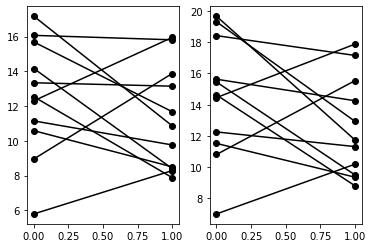

In [357]:
fig, ax = plt.subplots(1,2)
for i in range(len(distance_from_full_naive)):
    ax[0].plot([0, 1], [distance_from_full_naive[i], distance_from_full_expert[i]], 'o-', color='black')
    ax[1].plot([0, 1], [distance_from_pair_naive[i], distance_from_pair_expert[i]], 'o-', color='black')



### Distance must be compared with matched ROIs
- Fit in both, or either?

In [6]:
results_dir = Path(r'E:\TPM\JK\h5\results\neural_stretching\lda_performances')
expvar_results = pd.read_pickle(results_dir / 'explained_variances_expert_test_sessions.pkl')
expvar_comp_df = expvar_results[~((expvar_results.mouse==27) & (expvar_results.volume==1))]

In [8]:
touch_window = 'before_answer'
spk_norm = 'std'
varexp_threshold = 0.05
post_touch_frames = 1
row = expvar_comp_df.iloc[0]
mouse = row.mouse
volume = row.volume
session = row.session
top_plane = 1 if volume == 1 else 5
per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    get_touch_response_xr_varexp_threshold(mouse, top_plane, session, touch_window=touch_window,
                                            spk_norm=spk_norm, varexp_threshold=varexp_threshold,
                                            post_touch_frames=post_touch_frames)

In [ ]:
def get_distance_from_matched_rois(mouse, volume, sessions, touch_window='before_answer', spk_norm='std', varexp_threshold=0.05, post_touch_frames=1):
    distance_from_full_expert = []
    distance_from_pair_expert = []
    distance_from_full_naive = []
    distance_from_pair_naive = []
    for session in sessions:
        top_plane = 1 if volume == 1 else 5
        per_touch_response_xr_all = []
        per_touch_response_df_all = []
        for session in sessions:
            per_touch_response_xr, per_touch_response_df = \
                get_touch_response_volume_xr(mouse, top_plane, session, touch_window=touch_window,
                                            spk_norm=spk_norm, post_touch_frames=post_touch_frames)
            per_touch_response_xr_all.append(per_touch_response_xr)
            per_touch_response_df_all.append(per_touch_response_df)


    return 

In [9]:
touch_window = 'before_answer'
spk_norm = 'std'
varexp_threshold = 0.05
post_touch_frames = 1

mi = 0
volume = 1
top_plane = 1 if volume == 1 else 5

mouse = mice[mi]
sessions = test_sessions[mi]

per_touch_response_xr_all = []
per_touch_response_df_all = []
for session in sessions:
    per_touch_response_xr, per_touch_response_df = \
        get_touch_response_volume_xr(mouse, top_plane, session, touch_window=touch_window,
                                    spk_norm=spk_norm, post_touch_frames=post_touch_frames)
    per_touch_response_xr_all.append(per_touch_response_xr)
    per_touch_response_df_all.append(per_touch_response_df)


In [23]:
reload(mr)

<module 'matched_roi' from 'c:\\Users\\shires\\Dropbox\\Works\\Projects\\2020 Neural stretching in S1\\Analysis\\codes\\data_analysis\\matched_roi.py'>

In [24]:
roi_ind_matched_all = mr.get_matched_volume_roi_inds_ordered(base_dir, mouse, top_plane, sessions)

In [27]:
per_touch_response_xr_matched_all = []
for si in range(len(sessions)):
    per_touch_response_xr_matched_all.append(per_touch_response_xr_all[si].sel(cell_id=roi_ind_matched_all[si]))

Text(0.5, 0.98, 'JK025 Volume 1 Touch before_answer')

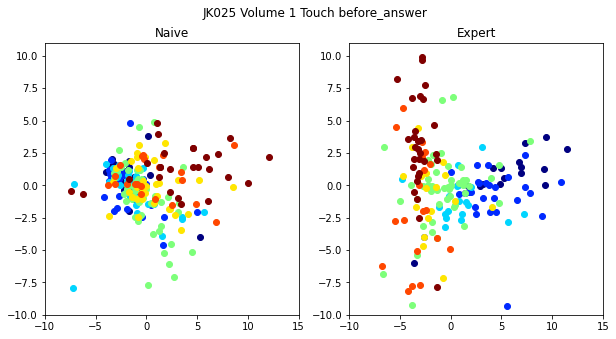

In [34]:
ylims = [-10, 11]
xlims = [-10, 15]
fig, ax = plt.subplots(1,2, figsize=(10,5))
_draw_pca(per_touch_response_xr_matched_all[0], per_touch_response_df_all[0], ax[0], standardization=True, pcs=[0,1])
_draw_pca(per_touch_response_xr_matched_all[1], per_touch_response_df_all[1], ax[1], standardization=True, pcs=[0,1])
ax[0].set_title('Naive')
ax[1].set_title('Expert')
for i in range(2):
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
fig.suptitle(f'JK{mouse:03} Volume {volume} Touch {touch_window}')

In [37]:
print(get_distance_45_135(per_touch_response_xr_matched_all[0], per_touch_response_df_all[0]))
print(get_distance_45_135(per_touch_response_xr_matched_all[1], per_touch_response_df_all[1]))

(9.34435, 11.319302)
(11.899385, 14.190654)


In [40]:
distance_from_full_expert = []
distance_from_pair_expert = []
distance_from_full_naive = []
distance_from_pair_naive = []
temp_df = expvar_comp_df[['mouse','volume']].drop_duplicates()
for _, row in temp_df.iterrows():
    mouse = row.mouse
    volume = row.volume
    sessions = expvar_comp_df.query('mouse == @mouse and volume == @volume').session.values
    top_plane = 1 if volume == 1 else 5

    per_touch_response_xr_all = []
    per_touch_response_df_all = []
    
    for session in sessions:
        per_touch_response_xr, per_touch_response_df = \
            get_touch_response_volume_xr(mouse, top_plane, session, touch_window=touch_window,
                                        spk_norm=spk_norm, post_touch_frames=post_touch_frames)
        per_touch_response_xr_all.append(per_touch_response_xr)
        per_touch_response_df_all.append(per_touch_response_df)
    roi_ind_matched_all = mr.get_matched_volume_roi_inds_ordered(base_dir, mouse, top_plane, sessions)
    per_touch_response_xr_matched_all = []
    for si in range(len(sessions)):
        per_touch_response_xr_matched_all.append(per_touch_response_xr_all[si].sel(cell_id=roi_ind_matched_all[si]))
    
    distance_full_all = []
    distance_pair_all = []
    for si in range(len(sessions)):
        distance_full, distance_pair = get_distance_45_135(per_touch_response_xr_matched_all[si], per_touch_response_df_all[si])
        distance_full_all.append(distance_full)
        distance_pair_all.append(distance_pair)
    
    distance_from_full_naive.append(distance_full_all[0])
    distance_from_pair_naive.append(distance_pair_all[0])
    
    distance_from_full_expert.append(distance_full_all[1])
    distance_from_pair_expert.append(distance_pair_all[1])


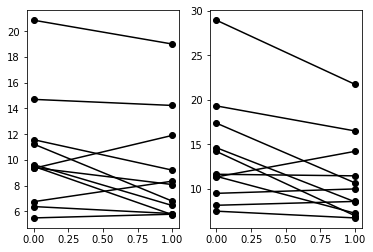

In [41]:
fig, ax = plt.subplots(1,2)
for i in range(len(distance_from_full_naive)):
    ax[0].plot([0, 1], [distance_from_full_naive[i], distance_from_full_expert[i]], 'o-', color='black')
    ax[1].plot([0, 1], [distance_from_pair_naive[i], distance_from_pair_expert[i]], 'o-', color='black')

### Look at the PCA domain first
- All matched ROIs, fit matched ROIs in either, and both

C:\Users\shires\AppData\Local\Temp/ipykernel_19992/3109191854.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2, figsize=(10,5))


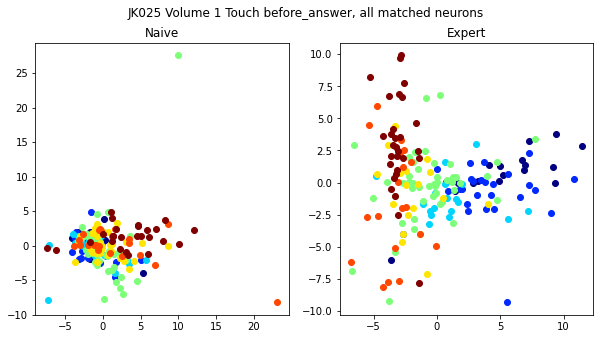

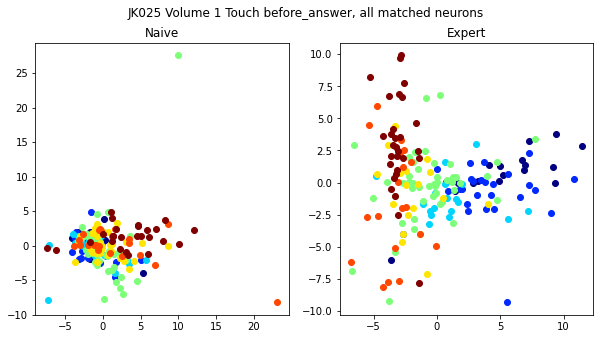

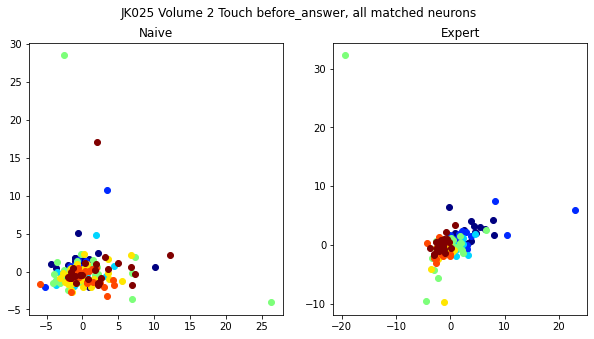

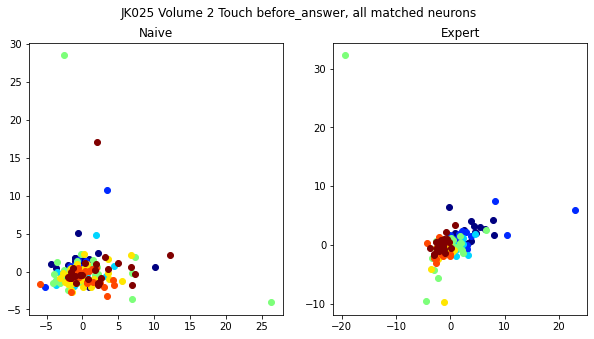

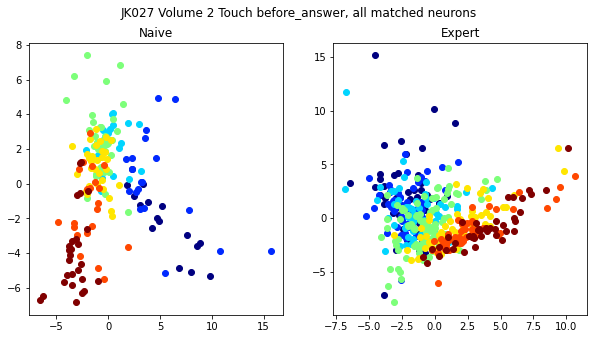

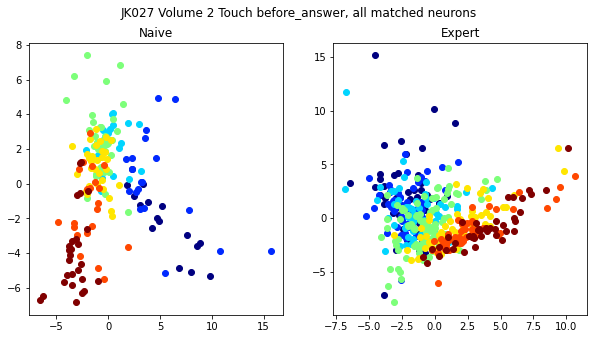

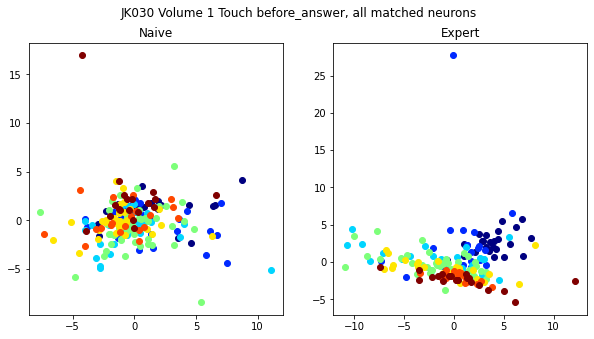

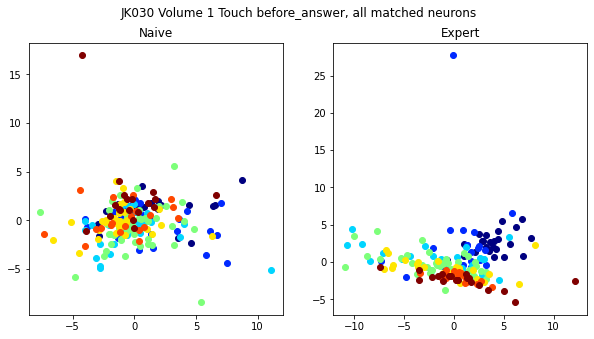

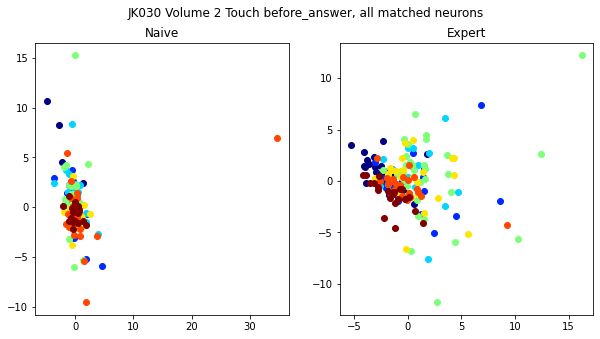

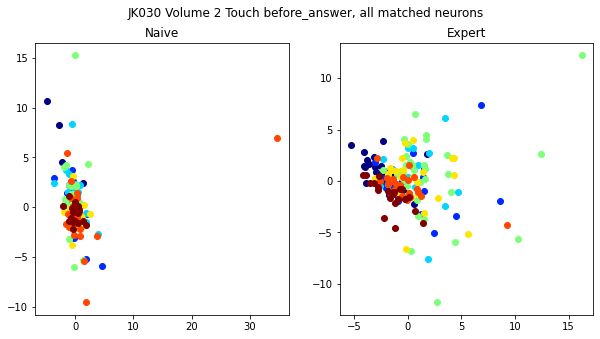

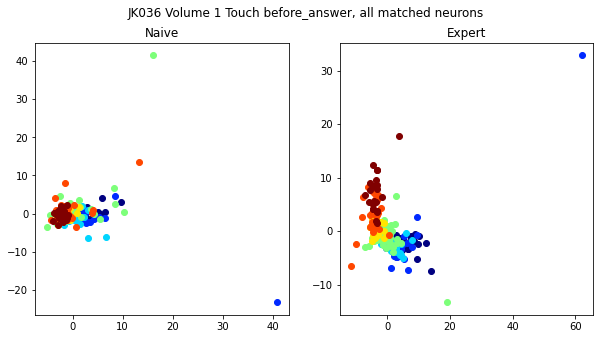

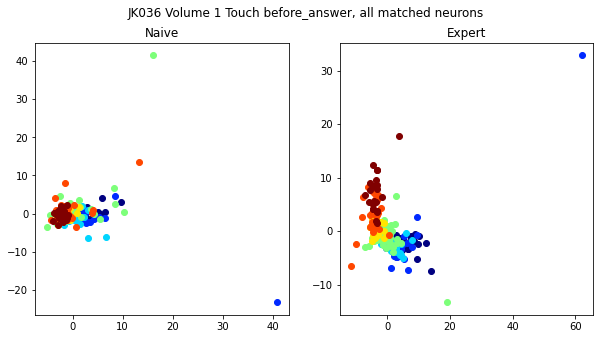

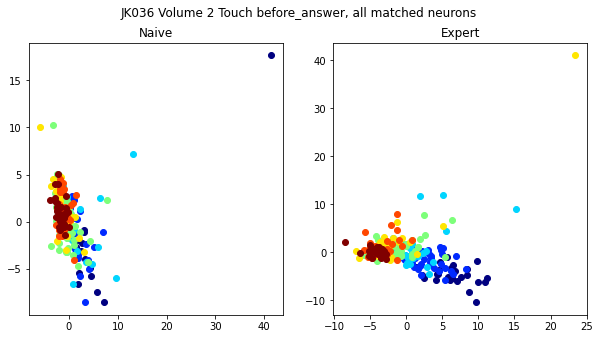

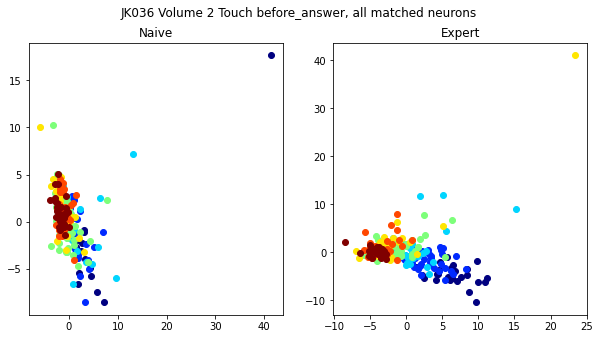

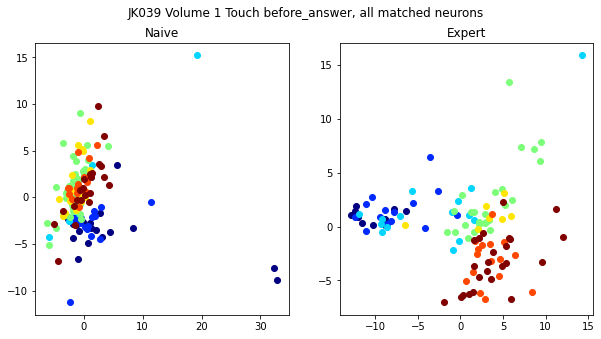

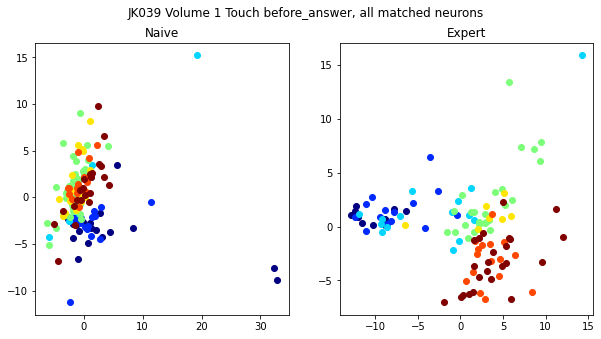

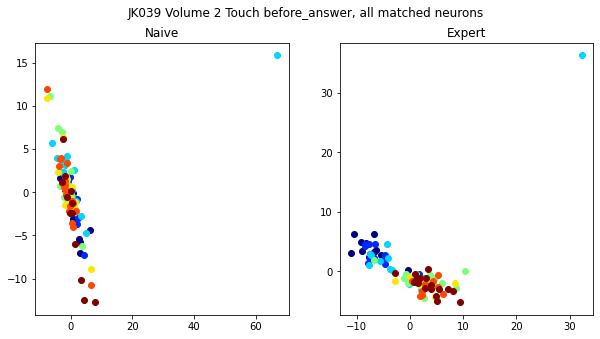

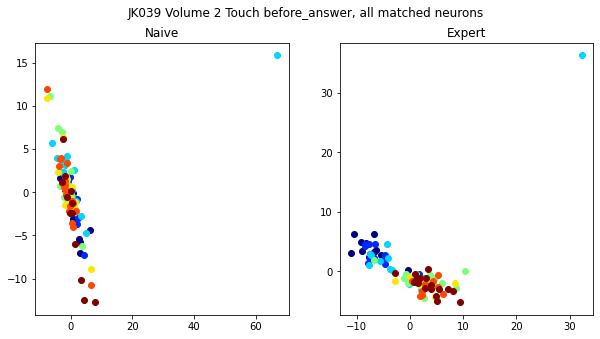

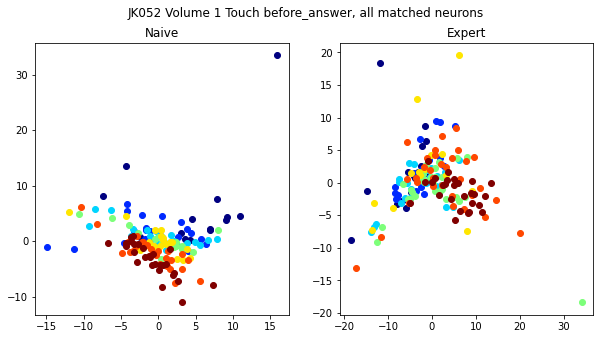

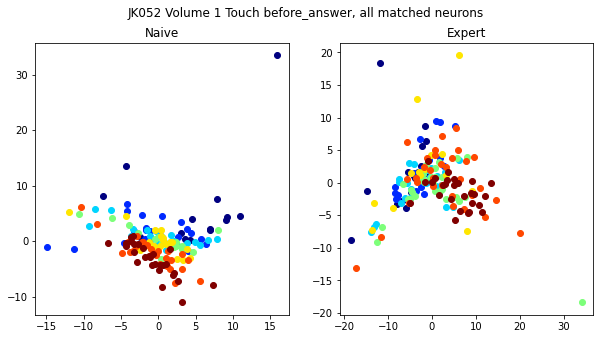

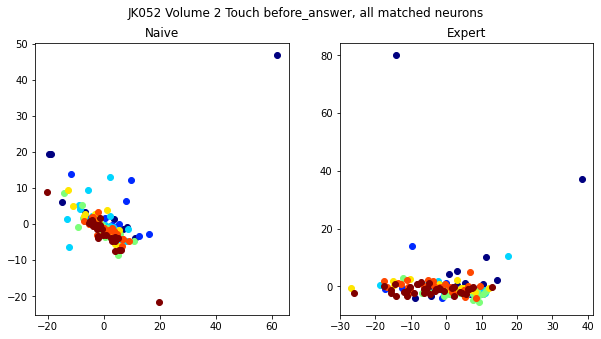

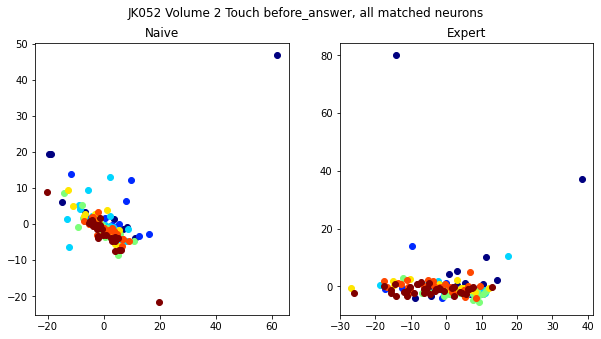

In [43]:
temp_df = expvar_comp_df[['mouse','volume']].drop_duplicates()

per_touch_response_xr_matched_all = []
for i, row in temp_df.iterrows():
    mouse = row.mouse
    volume = row.volume
    session = row.session
    top_plane = 1 if volume == 1 else 5

    per_touch_response_xr_all = []
    per_touch_response_df_all = []
    
    for session in sessions:
        per_touch_response_xr, per_touch_response_df = \
            get_touch_response_volume_xr(mouse, top_plane, session, touch_window=touch_window,
                                        spk_norm=spk_norm, post_touch_frames=post_touch_frames)
        per_touch_response_xr_all.append(per_touch_response_xr)
        per_touch_response_df_all.append(per_touch_response_df)
    roi_ind_matched_all = mr.get_matched_volume_roi_inds_ordered(base_dir, mouse, top_plane, sessions)
    per_touch_response_xr_matched_all = []
    for si in range(len(sessions)):
        per_touch_response_xr_matched_all.append(per_touch_response_xr_all[si].sel(cell_id=roi_ind_matched_all[si]))
    
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    _draw_pca(per_touch_response_xr_matched_all[0], per_touch_response_df_all[0], ax[0], standardization=True, pcs=[0,1])
    _draw_pca(per_touch_response_xr_matched_all[1], per_touch_response_df_all[1], ax[1], standardization=True, pcs=[0,1])
    ax[0].set_title('Naive')
    ax[1].set_title('Expert')
    fig.suptitle(f'JK{mouse:03} Volume {volume} Touch {touch_window}, all matched neurons')

# Instead of pairwise distance, compare clustering indext
- 

In [ ]:
distance_from_full_expert = []
distance_from_pair_expert = []
distance_from_full_naive = []
distance_from_pair_naive = []
temp_df = expvar_comp_df[['mouse','volume']].drop_duplicates()
for _, row in temp_df.iterrows():
    mouse = row.mouse
    volume = row.volume
    sessions = expvar_comp_df.query('mouse == @mouse and volume == @volume').session.values
    top_plane = 1 if volume == 1 else 5

    roi_ind_matched_all = mr.get_matched_volume_roi_inds_ordered(base_dir, mouse, top_plane, sessions)
    
    for si, session in enumerate(sessions):
        per_touch_response_xr, per_touch_response_df = \
            get_touch_response_volume_xr(mouse, top_plane, session, touch_window=touch_window,
                                        spk_norm=spk_norm, post_touch_frames=post_touch_frames)
        per_touch_response_xr = per_touch_response_xr.sel(cell_id=roi_ind_matched_all[si])
        distance_full, distance_pair = get_distance_45_135(per_touch_response_xr, per_touch_response_df)

        if session < 5:
            distance_from_full_naive.append(distance_full)
            distance_from_pair_naive.append(distance_pair)
        else:
            distance_from_full_expert.append(distance_full)
            distance_from_pair_expert.append(distance_pair)


In [ ]:
fig, ax = plt.subplots(1,2)
for i in range(len(distance_from_full_naive)):
    ax[0].plot([0, 1], [distance_from_full_naive[i], distance_from_full_expert[i]], 'o-', color='black')
    ax[1].plot([0, 1], [distance_from_pair_naive[i], distance_from_pair_expert[i]], 'o-', color='black')

## Heatmap of touch responses across cells and trials
- test on z-scored events
- sort trials by angles

In [18]:
mouse = 25
volume = 1
top_plane = 1 if volume == 1 else 5
session_type = 'test_expert'
sessions = use_mice_df.query('mouse == @mouse and plane == @top_plane and session_type == @session_type').session.unique().astype(int)
session = sessions[0]
spk_norm = 'std'
post_touch_frames = 1
per_touch_response_xr_fit, per_touch_response_df, per_touch_response_xr = \
    get_touch_response_xr_varexp_threshold(mouse, top_plane, session_type, spk_norm=spk_norm, varexp_threshold=0.05,
                                           post_touch_frames=post_touch_frames)


In [25]:
per_touch_response_xr_fit.dims

('trialNum', 'cell_id')

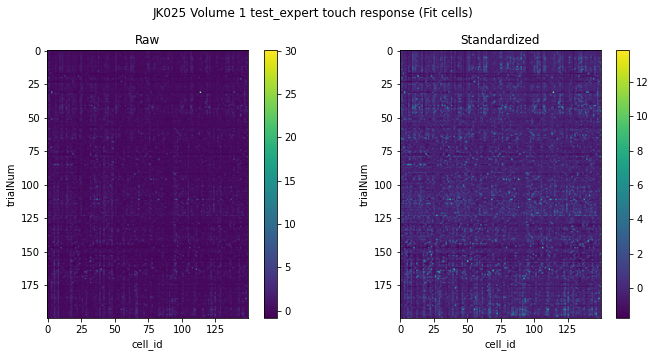

In [41]:
angles = np.sort(per_touch_response_df.pole_angle.unique())
trial_order = []
per_touch_response_fit = xr.DataArray(dims=['trialNum', 'cell_id'], coords={'trialNum': [], 'cell_id': []})
for angle in angles:
    trial_nums = per_touch_response_df.query('pole_angle == @angle').trialNum.values
    trial_order.extend(trial_nums)
    per_touch_response_fit= xr.concat([per_touch_response_fit,
                                      per_touch_response_xr_fit.sel(trialNum=trial_nums)],
                                      dim='trialNum')
per_touch_response_fit_std = (per_touch_response_fit - per_touch_response_fit.mean(dim='trialNum')) / per_touch_response_fit.std(dim='trialNum')

fig, ax = plt.subplots(1,2, figsize=(10,5))
im = ax[0].imshow(per_touch_response_fit)
cbar = fig.colorbar(im, ax=ax[0])
ax[0].set_title('Raw')
ax[0].set_xlabel(per_touch_response_fit.dims[1])
ax[0].set_ylabel(per_touch_response_fit.dims[0])
im = ax[1].imshow(per_touch_response_fit_std)
cbar = fig.colorbar(im, ax=ax[1])
ax[1].set_title('Standardized')
ax[1].set_xlabel(per_touch_response_fit_std.dims[1])
ax[1].set_ylabel(per_touch_response_fit_std.dims[0])
fig.suptitle(f'JK{mouse:03} Volume {volume} {session_type} touch response (Fit cells)')
fig.tight_layout()

### sorting cells by their tuned angle will be better.
- Come back this point after calculating angle tuning. (240224_angle_tuning_dev.ipynb)

### Compare dff, events, std events, and max-norm events.
- Choose which one to use.
- Syeda et al., 2023 used z-scored events.

# Check angle tuning 
- JK052 volume 2 & JK052 volume 2: naive neural stretching > expert

# Error sessions

In [185]:
use_mice_df.query('mouse==39')[['mouse','session','session_type']].drop_duplicates()

mouse session session_type
912      39       1   test_naive
914      39       3     training
915      39       4     training
916      39       5     training
917      39       6     training
918      39       7     training
919      39       8     training
920      39       9     training
921      39      10     training
922      39      11     training
923      39      12     training
924      39      13     training
925      39      14     training
926      39      15     training
927      39      16     training
928      39      17     training
930      39      19     training
931      39      20     training
932      39      21     training
933      39      22  test_expert
934      39      23  test_expert
1061     39       2     training

In [197]:
mouse = 39
session = 1
volume = 2
top_plane = 1 if volume == 1 else 5
planes = range(top_plane, top_plane + 4)
plane = planes[0]

# per_touch_response_xr, per_touch_response_df = get_touch_response(mouse, session, plane)

plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

# get spikes
spks = np.load(roi_dir / 'spks_reduced.npy')
iscell = np.load(roi_dir / 'iscell.npy')
cell_inds = np.where(iscell[:,0]==1)[0]
spks = spks[cell_inds,:]
assert spks.shape[1] == len(ophys_frametime)

# get merged df
merged_df = get_merged_df(ophys_frametime, behavior_frametime)

In [198]:
merged_df = assign_pole_moving_frames(merged_df)

C:\Users\shires\AppData\Local\Temp/ipykernel_35884/2689152529.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(


IndexError: index 31 is out of bounds for axis 0 with size 31

In [187]:
merged_df.columns

Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'remove_frame', 'remove_trial', 'amplitude',
       'answer_lick_frame', 'answer_lick_left', 'answer_lick_right',
       'answer_period_frame', 'arc_length_onset', 'correct', 'delta_kappaH',
       'delta_kappaV', 'delta_phi', 'delta_theta', 'distractor',
       'first_reward_lick_frame', 'first_reward_lick_left',
       'first_reward_lick_right', 'kappaH_onset', 'kappaV_onset', 'midpoint',
       'miss', 'mouse_name', 'num_lick_left', 'num_lick_right', 'num_whisks',
       'phi_onset', 'pole_angle', 'pole_ap_distance', 'pole_moving_frame',
       'pole_radial_distance', 'pole_up_frame', 'post_answer_pole_up_frame',
       'pre_answer_pole_up_frame', 'session_name', 'session_type',
       'slide_distance', 'task_target', 'theta', 'theta_onset', 'touch_count',
       'touch_duration', 'trial_type', 'wrong'],
      dtype='object')

### Assign pole_out_frame issue
- There are some cases where pole stayed up till the end of 2p frame
- How many?
- Why did it not error for GLM?

In [199]:
# one example from JK039 S1 plane 5
mouse = 39
session = 1
plane = 5
plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

merged_df = get_merged_df(ophys_frametime, behavior_frametime)

merged_df = merged_df.query('trial_type != "oo"').reset_index(drop=True)

assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame'] == 1)[0]) == 0).any()
merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(
    lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame'] == True)[0][0] - 1]).reset_index(
    drop=True)


In [219]:
def test_pole_up_frame_ind(mouse, session, plane):
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
    roi_dir = plane_dir / f'{session:03}/plane0/roi'
    ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

    merged_df = get_merged_df(ophys_frametime, behavior_frametime)

    merged_df = merged_df.query('trial_type != "oo"')

    assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame'] == 1)[0]) == 0).any()
    merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(
        lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame'] == True)[0][0] - 1]).reset_index(
        drop=True)
    
    last_pole_up_frame_ind = merged_df.groupby('trialNum').apply(lambda x: np.where(x['pole_up_frame'] == True)[0][-1])
    last_ind = merged_df.groupby('trialNum').apply(len)

    return len(np.where(last_pole_up_frame_ind.values - last_ind.values + 1 == 0)[0])

In [222]:
len(use_mice_df)

704

In [225]:
from tqdm.notebook import tqdm
num_trials_pole_stayed_up = []
for i, row in tqdm(use_mice_df.iterrows()):
    mouse = row.mouse
    session = int(row.session)
    plane = row.plane
    num_trials_pole_stayed_up.append(test_pole_up_frame_ind(mouse, session, plane))


0it [00:00, ?it/s]

C:\Users\shires\AppData\Local\Temp/ipykernel_35884/3396302973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(
C:\Users\shires\AppData\Local\Temp/ipykernel_35884/3396302973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(
C:\Users\shires\AppData\Local\Temp/ipykernel_35884/3396302973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [228]:
len(np.where(np.array(num_trials_pole_stayed_up)>0)[0])
# 11 out of 704 sessions

11

In [230]:
np.array(num_trials_pole_stayed_up)[np.where(np.array(num_trials_pole_stayed_up)>0)[0]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [229]:
use_mice_df.iloc[np.where(np.array(num_trials_pole_stayed_up)>0)[0]]
# 3 sessions - JK027 S04 v1, JK027 S12 v2, JK039 S01 v5
# all just by 1 trial

Unnamed: 0.1  mouse  plane session session_type  depth_matched  \
264            264     27      2       4     training           True   
285            285     27      3       4     training           True   
306            306     27      4       4     training           True   
334            334     27      5      12  test_expert           True   
361            361     27      6      12  test_expert           True   
388            388     27      7      12  test_expert           True   
415            415     27      8      12  test_expert           True   
1060          1060     39      5       1   test_naive           True   
1097          1097     39      6       1   test_naive           True   
1134          1134     39      7       1   test_naive           True   
1171          1171     39      8       1   test_naive           True   

      processing_error remove_frame_ind  
264              False      [5263 8768]  
285              False      [5263 8768]  
306              False      [5263 8768]  
334              False                0  
361              False                0  
388              False                0  
415              False                0  
1060             False                0  
1097             False                0  
1134             False                0  
1171             False                0

In [244]:
# Look at the error trial index from these sessions
mouse = 27
plane = 2
session = 4
plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

merged_df = get_merged_df(ophys_frametime, behavior_frametime)
merged_df = merged_df.query('trial_type != "oo"')

last_pole_up_frame_ind = merged_df.groupby('trialNum').apply(lambda x: np.where(x['pole_up_frame'] == True)[0][-1])
last_ind = merged_df.groupby('trialNum').apply(len)

print(np.where(last_pole_up_frame_ind.values - last_ind.values + 1 == 0)[0][0])
print(len(merged_df.trialNum.unique())-1)
print(len(last_pole_up_frame_ind.values)-1)

## JK027 S05 and JK039 S01 had the last trial with pole up till the end of the trial
## JK027 S04 had 215th out of 221 trials 

214
220
220


### Good enough to ignore no pole-out frame

In [255]:
merged_df.trialNum.unique()

array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 502, 503, 504, 505, 507, 508,
       509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
       535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 

In [258]:
temp_df = merged_df.query('trialNum == 2')
last_pole_up_frame_ind = np.where(temp_df['pole_up_frame'] == True)[0][-1]
temp_df['frame_index'] == temp_df['frame_index'].values[last_pole_up_frame_ind + 1]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39     True
40    False
41    False
42    False
43    False
Name: frame_index, dtype: bool

In [259]:
def _assign_pole_out_frame(x):
    last_pole_up_frame_ind = np.where(x['pole_up_frame'] == True)[0][-1]
    assert last_pole_up_frame_ind < len(x)
    if last_pole_up_frame_ind == len(x)-1:
        return x['frame_index'] == x['frame_index'].max() + 100
    else:
        return x['frame_index'] == x['frame_index'].values[last_pole_up_frame_ind + 1]

merged_df['pole_out_frame'] = merged_df.groupby('trialNum').apply(_assign_pole_out_frame).reset_index(
        drop=True)

### Why no error from GLM?
- I dealt with this problem there... (design_matrix.py)